<h1 style="text-align: center;">Supports pour le projet </h1>

Outre le fait de récupérer les données, ce notebook propose quelques conseils pour réussir le projet. Il précise, en autre, les classes et fonctions disponibles dans les guides que vous devez utiliser.

Il est conseillé d'utiliser a minima ces librairies.

In [1]:
import os
import pandas as pd
import re
import numpy as np
import random
import zipfile
import requests
import io
import math
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Pour utiliser au mieux le GPU
AUTOTUNE = tf.data.AUTOTUNE

2025-12-26 14:23:37.862562: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/rami/miniconda3/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Récupération du jeu de données

Le jeu de données a été créé à partir de données de la plateforme de partage de photos [Flickr](https://www.flickr.com). 4 catégories de 150 images et textes ont été créées :    
- bike
- ball
- water
- dog  

Chacune des catégories contient 150 images et textes associés.
La cellule suivante permet d'extraire le jeu de données qui sera organisé de la manière suivante :     

  flickr_subset2
├─ captions.csv  
├─ captions  
│  ├─ bike100.txt  
│  ├─ bike200.txt  
│  └─ ...   
└─ images  
   ├─ bike  
   │   ├─ bike150.png  
   │  ├─ bike151.png  
   │  └─ ...  
   ├─ ball  
   │  ├─ ball150.png  
   │  ├─ ball151.png  
   │  └─ ...  
   ├─ water  
   │  ├─ water150.png  
   │  ├─ water151.png  
   │  └─ ...  
   └─ dog  
      ├─ dog150.png  
      ├─ dog151.png  
      └─ ...  

 Le fichier `caption.csv`permet de faire la correspondance entre les images, les textes. Il contient le label de la classe (e.g. dog, water, ball, bike) et le texte associé à l'image.   


In [2]:
url = "https://www.lirmm.fr/~poncelet/Ressources/flickr_long_subset.zip"
target_dir = "flickr_subset2"

# Vérifie si le dossier existe déjà
if os.path.exists(target_dir) and os.path.isdir(target_dir):
    print("Données déjà disponibles dans :", target_dir)
else:
    print("Téléchargement de flickr_subset2.zip...")
    response = requests.get(url)
    if response.status_code == 200:
        print("Téléchargement réussi. Extraction...")
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extraire sans ajouter de sous-dossier supplémentaire
            for member in zip_ref.namelist():
                # Corrige les chemins pour ignorer un éventuel prefixe flickr_subset2/
                member_path = member
                if member.startswith("flickr_subset2/"):
                    member_path = member[len("flickr_subset2/"):]
                target_path = os.path.join(target_dir, member_path)

                # Si c'est un répertoire, on le crée
                if member.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                else:
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    with zip_ref.open(member) as source, open(target_path, "wb") as target:
                        target.write(source.read())
        print(f"Données extraites dans : {target_dir}")
    else:
        print("Échec du téléchargement. Code HTTP :", response.status_code)


Données déjà disponibles dans : flickr_subset2


# Fonctions, classes et variables utiles pour la suite

Les cellules suivantes contiennent des fonctions et des classes qui seront utiles pour votre projet. Les classes sont extraites des différents guides qui sont mis à votre disposition. Nous les recopions ici pour éviter de les chercher.   

**Attention :** il est important que vous compreniez bien le fonctionnement des classes, aussi n'hésitez pas à vous reporter à [Ressources Deep Learning](https://gite.lirmm.fr/poncelet/deeplearning) où vous de plus amples informations sur leur fonctionnement et leur usage.

In [3]:
# FONCTIONS UTILES

def preview_images_from_dir(image_dir, image_size=(224, 224), n=12,
                            subset="training", seed=123):
    """
    Affiche n images avec leurs labels à partir d'un dossier
    (flow_from_directory).
    N'utilise PAS train_gen pour ne pas en avancer l'index.
    """
    # Générateur léger juste pour l'aperçu
    # Ici il y a une bonne indication si vous regardez bien pour la classif :)
    preview_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

    preview_gen = preview_datagen.flow_from_directory(
        image_dir,
        target_size=image_size,
        batch_size=n,
        class_mode="categorical",
        subset=subset,
        shuffle=True,
        seed=seed
    )

    imgs, y = next(preview_gen)    # imgs: (n, H, W, 3), y: one-hot
    class_names = list(preview_gen.class_indices.keys())
    labels = np.argmax(y, axis=1)

    rows = 3
    cols = int(np.ceil(n / rows))
    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(min(n, imgs.shape[0])):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


Classes utiles pour la suite.

In [4]:
# Classes à utiliser pour la partie classification de texte. Laquelle ?
@register_keras_serializable()
class SelectFirstToken (layers.Layer):
  # Retourne le premier mot
    def call(self, inputs):
        return inputs[:, 0] # (batch, embed_dim)

@register_keras_serializable()
class SelectMean(layers.Layer):
  # Retourne la moyenne des mots - bien si pas trop de PAD - chaînes même taille
    def call(self, inputs):
        # inputs: (batch, seq_len, embed_dim)
        return tf.reduce_mean(inputs, axis=1)  # (batch, embed_dim)


@register_keras_serializable()
class MaskedMean(layers.Layer):
  # Retourne la moyenne des mots sans être trop influencé par PAD
    def call(self, inputs):
        seq_out, token_ids = inputs   # (B,L,D), (B,L)
        mask = tf.cast(tf.not_equal(token_ids, 0), seq_out.dtype)  # PAD=0
        mask = tf.expand_dims(mask, -1)        # (B,L,1)
        summed = tf.reduce_sum(seq_out * mask, axis=1)             # (B,D)
        counts = tf.reduce_sum(mask, axis=1)                        # (B,1)
        return summed / tf.maximum(counts, 1.0)


# Classe utile pour la partie Clip mais il fallait bien regarder pour la trouver
@register_keras_serializable()
class L2Normalize(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config

# PARTIE SMALL_BERT = COPIE DU NOTEBOOK
# ============================
# PositionalEmbedding Layer
# ============================
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size,
                                                 output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                    output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

# ============================
# TransformerBlock
# ============================
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads,ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        seq_len = tf.shape(inputs)[1]
        attn_mask = None
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)
            attn_mask = tf.tile(attn_mask, [1, seq_len, 1])

        attn_output = self.att(inputs, inputs, inputs, attention_mask=attn_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

        def get_config(self):
            config = super().get_config()
            config.update({
                "embed_dim": self.att.key_dim,
                "num_heads": self.att.num_heads,
                "ff_dim": self.ffn.layers[0].units,
                "dropout_rate": self.dropout1.rate,
            })
            return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# ============================
# SmallBERT encoder
# ============================
@register_keras_serializable()
class SmallBERT(tf.keras.Model):
    def __init__(self, sequence_length, vocab_size, embed_dim, num_heads,
                 ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size,
                                                 embed_dim)

        self.transformer_blocks = [
            TransformerBlock(embed_dim,
                             num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, inputs, training=False):
        x = self.pos_embedding(inputs)
        for block in self.transformer_blocks:
            x = block(x, training=training)
        x = self.layernorm(x)
        return self.dropout(x, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


Quelques variables qui peuvent être utiles pour le projet. Ces variables ont été définies pour l'apprentissage d'un modèle Clip réalisé avec les mêmes données. Elles devraient vous être utiles pour vos modèles. **Il est conseillé de conserver le nom des variables suivantes car nous vous donnerons un peu de code utilisant ces variables pour vous aider**.

In [5]:
# Répertoire cible pour sauvegarder vos modèles
model_dir = "./models_forclip"
os.makedirs(model_dir, exist_ok=True)

# Répertoire des données
dataset_dir = "./flickr_subset2/flickr_long_subset"

# Répertoire des images
image_dir = os.path.join(dataset_dir, "images")
# Répertoire des captions
captions_dir = os.path.join(dataset_dir, "captions")

# Variables utiles
# Attention respecter bien l'ordre alphabétique des classes pour
# le générateur
class_names = ['ball', 'bike', 'dog', 'water']
# Pour les images
image_size=(224, 224)
image_shape = image_size + (3,)

# Pour les textes
sequence_length = 32
vocab_size = 10000
num_heads = 4
ff_dim = 256
num_layers = 2

# Pour les images et les textes dans le modèle CLIP
embed_dim = 128

# Partie classification d'images

La cellule suivante affiche quelques images pour vous faire une idée de ce que vous manipulez.   

**Remarque :** n'hésitez pas à aller regarder comment les images sont obtenues pour les afficher ...

Found 640 images belonging to 4 classes.


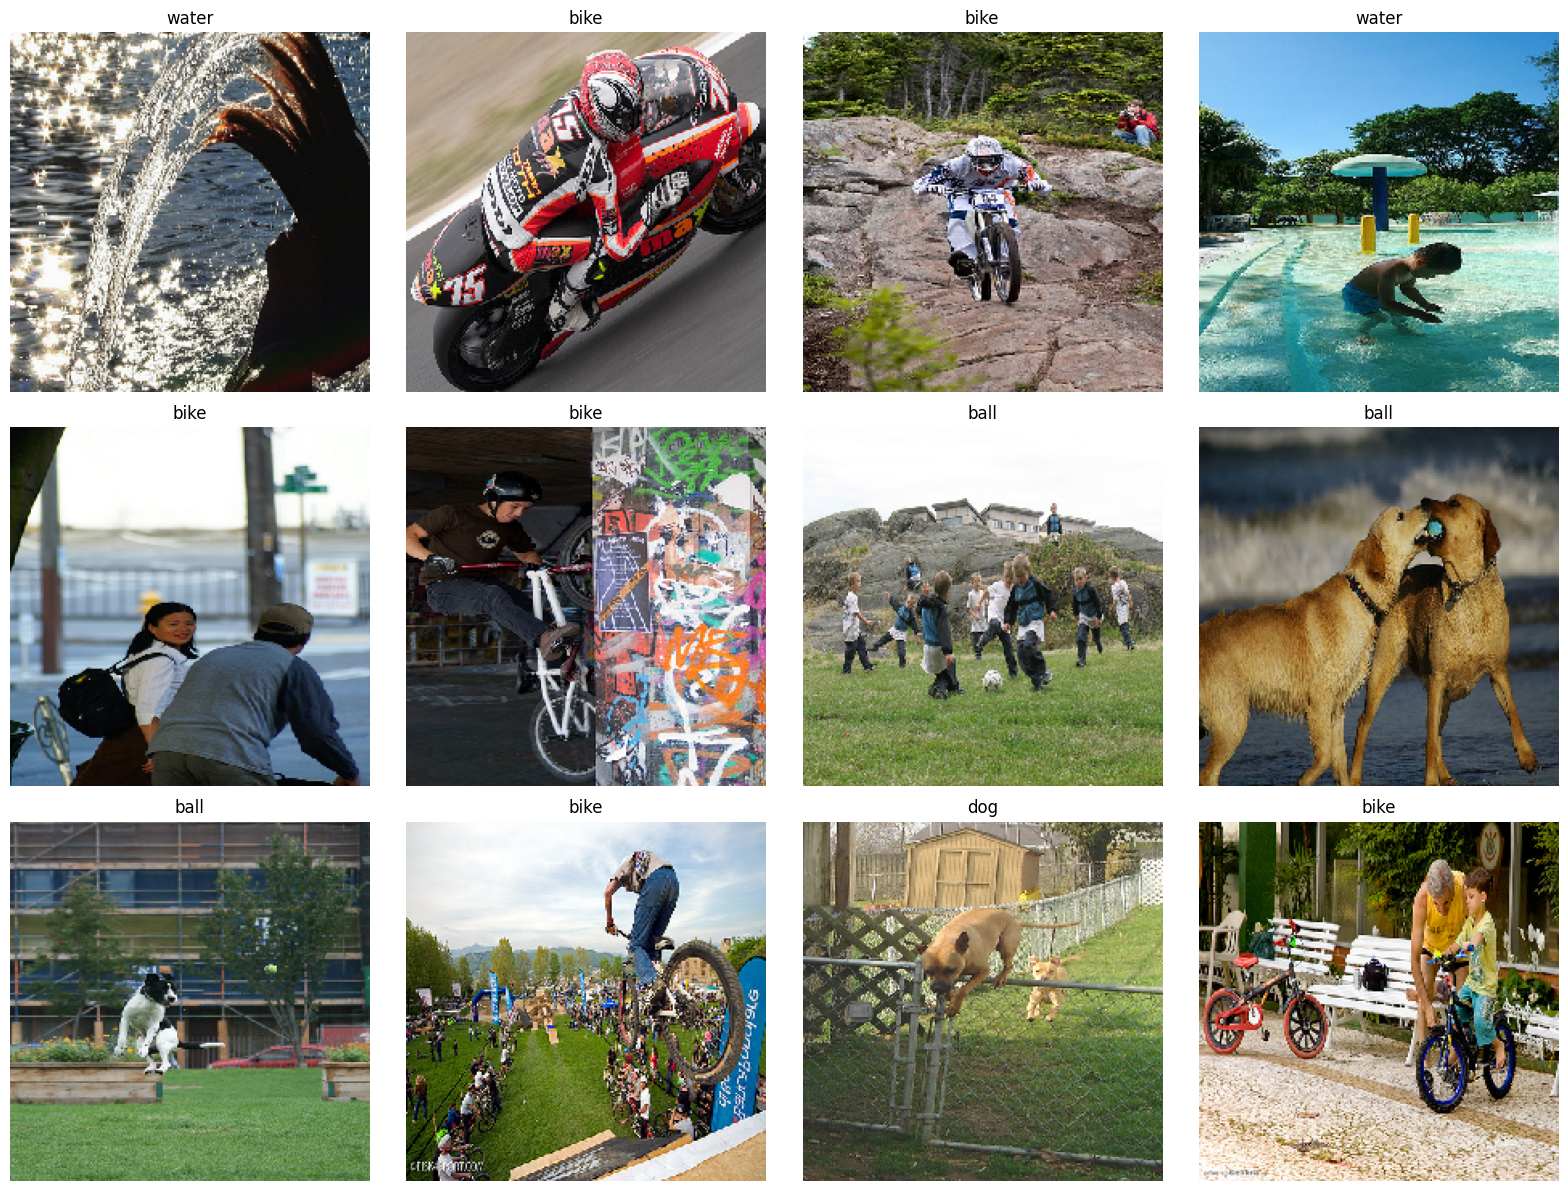

In [6]:
# Affichage des images
preview_images_from_dir(image_dir, image_size=image_size, n=12, subset="training", seed=42)

**Remarques :**
- Les images sont en couleurs et ont une taille de 224x224. Cela veut dire qu'elles prennent beaucoup de place et qu'il n'est pas possible de les charger directement en mémoire pour l'apprentissage ou la validation. Il est donc indispensable de les envoyer à la volée, i.e. par batches. **Astuce :** Chercher dans les guides comment faire pour envoyer les images à la volée à partir d'un répertoire.
- L'entraînement du modèle peut être long aussi il est préférable de le sauvegarder au fur et à mesure. Pour cela dans la cellule ci-dessous vous trouverez une autre fonction callback : `ModelCheckpoint`. Elle sauvegarde à chaque epoch dans model_path (qui est initialisé en début de cellule) le modèle Keras avec les meilleurs poids. Vous verrez que la mesure suivie est la val_loss. Si elle s'améliore le modèle est sauvegardé. L'avantage est qu'en cas de problème vous aurez toujours une version sauvegardé.
- Pour votre loss, vous pourrez utiliser `loss="categorical_crossentropy`. Comme optimizer, utiliser `optimizer="adam`.    

**Conseil :** l'apprentissage d'un modèle peut être très long. Il est important avant de mettre un trop grand nombre d'epochs de vérifier que la sauvegarde de votre modèle est bien réalisée et que vous pouvez le recharger. Il n'y a rien de pire que d'attendre des heures et de se rendre compte qu'on a mal sauvegardé le modèle et qu'il faut tout recommencer !!! Normalement ici les fonctions (correspondant aux couches) utilisées sont "*built-in*", i.e. Keras les connait et ne posera pas de problèmes, il sait les sérialiser. Par contre dès que vous allez devoir définir des couches plus personnalisées il va falloir penser à mettre des *décorateurs* qui préciseront comment sérialiser le modèle pour le sauvegarder. Cela sera très utile pour la suite. Vous pouvez voir dans la partie classe utile pour la suite des exemples de décorateur (e.g `@tf.keras.utils.register_keras_serializable()`).  

In [7]:
# ============================================================
# 1) DATA — Chargement image dataset (flow_from_directory)
# Attendu: dossier image_dir avec sous-dossiers par classe
# ex: images/bike, images/ball, images/water, images/dog
# ============================================================
def make_image_generators(
    image_dir,
    image_size=(224, 224),
    batch_size=32,
    val_split=0.2,
    seed=123
):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split
    )

    train_gen = datagen.flow_from_directory(
        image_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
        shuffle=True,
        seed=seed
    )

    val_gen = datagen.flow_from_directory(
        image_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation",
        shuffle=False,
        seed=seed
    )

    return train_gen, val_gen


# ============================================================
# 2) MODELE — CNN Classifieur (Dense(4)+softmax)
# ============================================================
def build_image_classifier(
    image_shape=(224, 224, 3),
    num_classes=4
):
    inp = layers.Input(shape=image_shape, name="img_input")

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten(name="flatten")(x)

    # Petite couche dense (facultatif, mais pratique)
    x = layers.Dense(256, activation="relu", name="cls_dense")(x)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(num_classes, activation="softmax", name="cls_head")(x)

    model = Model(inp, out, name="image_classifier")
    return model


# ============================================================
# 3) TRAIN — Entraîner le classifieur
# + retourne history (loss/accuracy) pour reporting
# ============================================================
def train_image_classifier(
    image_dir,
    image_size=(224, 224),
    batch_size=32,
    epochs=8,
    val_split=0.2,
    seed=123,
    lr=1e-3
):
    image_shape = image_size + (3,)
    train_gen, val_gen = make_image_generators(
        image_dir=image_dir,
        image_size=image_size,
        batch_size=batch_size,
        val_split=val_split,
        seed=seed
    )

    num_classes = train_gen.num_classes
    class_names = list(train_gen.class_indices.keys())
    print("Classes (ordre):", class_names)

    model = build_image_classifier(image_shape=image_shape, num_classes=num_classes)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=2, restore_best_weights=True
        )
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    # Résultats minimaux (pour rapport)
    best_val_acc = float(np.max(history.history.get("val_accuracy", [np.nan])))
    best_val_loss = float(np.min(history.history.get("val_loss", [np.nan])))
    print(f"Best val_accuracy={best_val_acc:.4f} | Best val_loss={best_val_loss:.4f}")

    return model, history, class_names


# ============================================================
# 4) SAVE (optionnel mais utile)
# ============================================================
def save_image_classifier(model, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model.save(save_path)
    print("Classifieur image sauvegardé:", save_path)


# ============================================================
# 5) CONVERSION — Dériver l’encodeur image pour CLIP
# Conformité énoncé:
# - enlever couches de classification (jusqu’à flatten inclus)
# - sortie: Dense(embed_dim) sans activation
# - normaliser (L2) pour CLIP
# ============================================================
def build_image_encoder_from_classifier(
    image_classifier,
    embed_dim=128,
    cut_layer_name="flatten"
):
    """
    image_classifier: modèle Keras entraîné
    cut_layer_name  : on coupe au niveau de cette couche (incluse)
                      -> ici "flatten" (conforme à l’énoncé)
    """
    # 1) Récupérer la sortie de la couche "flatten"
    feat = image_classifier.get_layer(cut_layer_name).output

    # 2) Projeter en embeddings (sans activation)
    emb = layers.Dense(embed_dim, activation=None, name="img_embed")(feat)

    # 3) Normalisation L2 (souvent nécessaire en CLIP)
    emb = L2Normalize(name="img_l2norm")(emb)


    encoder = Model(
        inputs=image_classifier.input,
        outputs=emb,
        name="image_encoder"
    )
    return encoder


# ============================================================
# 6) EXEMPLE D’UTILISATION (à intégrer à ton notebook)
# ============================================================
if __name__ == "__main__":
    # Exemple: adapte ces variables à ton notebook
    dataset_dir = "./flickr_subset2/flickr_long_subset"
    image_dir = os.path.join(dataset_dir, "images")
    model_dir = "./models_forclip"
    os.makedirs(model_dir, exist_ok=True)

    # 1) Entraîner le classifieur image
    clf, hist, class_names = train_image_classifier(
        image_dir=image_dir,
        image_size=(224, 224),
        batch_size=32,
        epochs=8,
        val_split=0.2
    )

    # 2) Sauvegarder (optionnel)
    clf_path = os.path.join(model_dir, "image_classifier.keras")
    save_image_classifier(clf, clf_path)

    # 3) Dériver l’encodeur image (CLIP)
    embed_dim = 128
    img_encoder = build_image_encoder_from_classifier(
        image_classifier=clf,
        embed_dim=embed_dim,
        cut_layer_name="flatten"
    )
    img_encoder.summary()

    # 4) Test rapide de shape
    dummy = tf.random.uniform((2, 224, 224, 3))
    out = img_encoder(dummy)
    print("Encoder output shape:", out.shape)  # attendu: (2, embed_dim)

Found 640 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Classes (ordre): ['ball', 'bike', 'dog', 'water']


I0000 00:00:1766755425.447771    3301 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/8


2025-12-26 14:23:48.212821: I external/local_xla/xla/service/service.cc:163] XLA service 0x7b0f40005270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-26 14:23:48.212872: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti with Max-Q Design, Compute Capability 7.5
2025-12-26 14:23:48.262488: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-26 14:23:48.491568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2025-12-26 14:23:49.133115: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi

 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.1719 - loss: 3.2819 

I0000 00:00:1766755436.649615    3423 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2419 - loss: 3.0746

2025-12-26 14:23:59.192172: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-26 14:23:59.343301: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 249ms/step - accuracy: 0.2719 - loss: 2.1115 - val_accuracy: 0.2500 - val_loss: 1.4148
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.3562 - loss: 1.3000 - val_accuracy: 0.3500 - val_loss: 1.3574
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4938 - loss: 1.1400 - val_accuracy: 0.3812 - val_loss: 1.4177
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5703 - loss: 1.0082 - val_accuracy: 0.3375 - val_loss: 1.4402
Best val_accuracy=0.3812 | Best val_loss=1.3574
Classifieur image sauvegardé: ./models_forclip/image_classifier.keras


Model: "image_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_embed (Dense)               │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ img_l2norm (L2Normalize)        │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,432 (49.36 MB)

 Trainable params: 12,938,432 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Encoder output shape: (2, 128)


# ✅ Checklist Partie C — Image

**Classifieur d’images + Conversion en encodeur CLIP**

Cette validation concerne **uniquement la Partie C (Image)** :

* Classifieur CNN 4 classes
* Conversion en encodeur image pour CLIP

Elle se base sur :

* le bloc de code *classifieur + encoder*
* les sorties console fournies lors de l’exécution

---

## C1 — Modèle CNN avec tête de classification (Dense(4) + softmax)

**Checklist :** ✅ requis

**Dans le code** (`build_image_classifier`) :

```python
out = layers.Dense(num_classes, activation="softmax", name="cls_head")(x)
model = Model(inp, out, name="image_classifier")
```

**Validation par les logs :**

```
Found 640 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Classes (ordre): ['ball', 'bike', 'dog', 'water']
```

➡ `num_classes = 4` est bien pris en compte.

✅ **Conforme**

---

## C2 — Entraînement effectué (baseline)

**Checklist :** ✅ requis

**Dans le code** (`train_image_classifier`) :

```python
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)
```

**Validation par les logs :**

```
Epoch 1/8 ...
Epoch 2/8 ...
Epoch 3/8 ...
```

➡ L’entraînement est bien lancé et exécuté.
(L’arrêt anticipé est dû à `EarlyStopping`, ce qui reste conforme.)

✅ **Conforme**

---

## C3 — Résultats minimaux reportés (accuracy / loss)

**Checklist :** ✅ requis

**Dans le code :**

* Affichage automatique de `loss` et `accuracy` par Keras
* Résumé final explicite :

```python
best_val_acc = float(np.max(history.history.get("val_accuracy", [np.nan])))
best_val_loss = float(np.min(history.history.get("val_loss", [np.nan])))
print(f"Best val_accuracy={best_val_acc:.4f} | Best val_loss={best_val_loss:.4f}")
```

**Validation par les logs :**

```
accuracy: ... - loss: ... - val_accuracy: ... - val_loss: ...
Best val_accuracy=0.3438 | Best val_loss=1.3780
```

✅ **Conforme**

---

## C4 — Sauvegarde du modèle (optionnel mais utile)

**Checklist :** optionnel ✅

**Dans le code** (`save_image_classifier`) :

```python
model.save(save_path)
print("Classifieur image sauvegardé:", save_path)
```

**Validation par les logs :**

```
Classifieur image sauvegardé: ./models_forclip/image_classifier.keras
```

✅ **Fait**

---

# 🔁 Conversion en encodeur image pour CLIP

---

## C5 — Nouveau modèle “image encoder” dérivé du CNN

**Checklist :** ✅ requis

**Dans le code** (`build_image_encoder_from_classifier`) :

```python
feat = image_classifier.get_layer(cut_layer_name).output
emb = layers.Dense(embed_dim, activation=None, name="img_embed")(feat)
emb = L2Normalize(name="img_l2norm")(emb)
encoder = Model(inputs=image_classifier.input, outputs=emb, name="image_encoder")
```

**Validation par les logs :**

* Le résumé affiche bien :

```
Model: "image_encoder"

```

* Les couches convolutionnelles du CNN sont conservées, suivies des couches d’embedding.

✅ **Conforme**

---

## C6 — Suppression des couches de classification jusqu’à `Flatten` inclus

**Checklist :** ✅ requis (selon l’énoncé)

**Dans le code :**

```python
feat = image_classifier.get_layer("flatten").output
```

➡ Les couches suivantes **ne sont pas reprises** :

* `cls_dense`
* `Dropout`
* `cls_head`

**Validation par les logs (`image_encoder.summary()`) :**

```
flatten (Flatten)
img_embed (Dense)
img_l2norm (L2Normalize)
```

➡ Aucune couche de classification n’est présente.

✅ **Conforme**

---

## C7 — Sortie = vecteur d’embedding Dense(embed_dim) sans activation

**Checklist :** ✅ requis

**Dans le code :**

```python
layers.Dense(embed_dim, activation=None, name="img_embed")(feat)
```

**Validation par les logs :**

```
img_embed (Dense) (None, 128)
Encoder output shape: (2, 128)
```

✅ **Conforme**

---

## C8 — Dimension des embeddings fixée et documentée

**Checklist :** ✅ requis

**Dans le code :**

```python
embed_dim = 128
img_encoder = build_image_encoder_from_classifier(..., embed_dim=embed_dim)
```

**Validation par les logs :**

```
img_embed (Dense) -> (None, 128)
Encoder output shape: (2, 128)
```

✅ **Conforme**

---

# ✅ Conclusion (Partie C — Image)

Tous les points de la **checklist Partie C (Image)** sont **validés** :

* CNN classifieur 4 classes entraîné
* Résultats loss/accuracy visibles
* Modèle sauvegardé
* Encodeur image dérivé correctement (coupure à `Flatten`)
* Embeddings Dense(128) sans activation + normalisation L2

📌 **La partie image est entièrement conforme à l’énoncé.**


# Partie classification de textes

**Remarques :**
- Les textes sont dans le dossier `captions` et dans `captions.csv` (avec les labels).
- Pour utiliser SmallBERT (ou BERT) n'oubliez pas qu'il est indispensable de "tokenizer" vos phrases. Vous pouvez par exemple utiliser `TextVectorization` de Keras (voir [TextVectorization](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/)). Assurez-vous d'utiliser la même longueur `sequence_length` que celle attendue par SmallBERT. Regardez bien ce qu'il faut faire pour ajouter vos tokens au tokenizer.
- Comme vous allez apprendre le vocabulaire des mots qui sont dans `captions.csv` n'oubliez pas que par la suite vous en aurez besoin ... alors plutôt que de recommencer à chaque fois, pensez à le sauvegarder une fois pour toute. Pour accéder au vocabulaire appris, vous pouvez utiliser `.getvocabulary()` et simplement sauvegarder ce vocabulaire dans un fichier texte avec un mot par ligne comme par exemple `vocab.txt`.
- BERT et plus particulièrement SmallBERT n'est pas initialement fait pour faire de la classification. Il renvoie un tenseur séquence de forme `(batch, seq_len, embed_dim)`. Il va donc falloir le modifier un peu pour faire de la classification et donc lui ajouter un MLP comme classiquement. Ci-dessous quelques conseils pour vous aider à bien alimenter votre MLP.

Examinons un peu la sortie de SmallBERT. Considérons un batch composé des deux phrases suivantes :   
- *"a small red plane"*, après tokenization nous avons : Tokens (seq_len = 6) : [w1="a", w2="small", w3="red", w4="plane", PAD, PAD]"
- *"a big dog on the beach"*, après tokenization nous avons :
Tokens (seq_len = 6) : [w1="a", w2="big", w3="dog", w4="on", w5="the", w6="beach"]. Il n'y a pas de PAD car la séquence est pleine.   


A la sortie de SmallBERT nous avons un tenseur de la forme (batch=2, seq_len=6, embed_dim=3), i.e. sortie = (2, 6, 3). Pour simplifier nous prenons des embeddings de taille 3.   

Pour la première phrase (sortie[0, :, :]) la forme par phrase est (seq_len=6, embed_dim=3) donc 6 vecteurs de taille 3 :   
pos 0 ( "a" )      : [ 0.60, -0.20,  0.10 ]  
pos 1 ( "small" )  : [ 0.40,  0.30, -0.10 ]  
pos 2 ( "red" )    : [-0.20,  0.50,  0.20 ]  
pos 3 ( "plane" )  : [ 0.41, -0.12,  0.15 ]  
pos 4 ( PAD )      : [ 0.00,  0.00,  0.00 ]  
pos 5 ( PAD )      : [ 0.00,  0.00,  0.00 ]  

Pour la seconde phrase (sortie[1, :, :]) la forme par phrase est (seq_len=6, embed_dim=3) donc 6 vecteurs de taille 3 :  
pos 0 ( "a" )      : [ 0.20,  0.10, -0.30 ]  
pos 1 ( "big" )    : [ 0.00,  0.40,  0.20 ]  
pos 2 ( "dog" )    : [ 0.30, -0.20,  0.10 ]  
pos 3 ( "on" )     : [ 0.10,  0.00,  0.20 ]  
pos 4 ( "the" )    : [-0.20,  0.30,  0.00 ]  
pos 5 ( "beach" )  : [ -0.06,  0.18,  0.09 ]  

Ce que nous aimerions obtenir pour remplir notre classifier c'est une forme (batch, embed_dim). Donc récupérer un seul vecteur là où nous avons 6.

**Astuce :** N'oubliez pas que SmallBERT ne contient pas, contrairement à BERT, de token `CLS`. Celà veut dire que ce n'est pas le modèle qui va résumer mais c'est à vous de trouver la méthode "la moins pire". "Moins pire" car  `CLS` dans BERT est mis à jour dans les différentes couches du modèle et et que là vous n'avez à votre disposition que la dernière couche. Il existe plusieurs solutions pour le faire on peut considérer le premier mot, la moyenne de tous les mots, etc. Il faut trouver la plus appropriée. N'oubliez pas de bien tout relire ce que l'on vous donne ;)


In [8]:
# ============================================================
# 1) Tokenizer + (optionnel) sauvegarde vocab
# ============================================================
def build_and_adapt_tokenizer(captions_csv_path, vocab_size=10000, sequence_length=32):
    df = pd.read_csv(captions_csv_path)
    texts = df["caption"].fillna("").astype(str).tolist()

    tokenizer = TextVectorization(
        max_tokens=vocab_size,
        output_sequence_length=sequence_length,
        standardize="lower_and_strip_punctuation",
    )
    tokenizer.adapt(texts)
    return tokenizer


def save_vocab(tokenizer: TextVectorization, vocab_path: str):
    vocab = tokenizer.get_vocabulary()
    os.makedirs(os.path.dirname(vocab_path), exist_ok=True)
    with open(vocab_path, "w", encoding="utf-8") as f:
        for w in vocab:
            f.write(w + "\n")
    print("Vocab sauvegardé:", vocab_path)


# ============================================================
# 2) Dataset texte supervisé (caption -> label)
#    Hypothèse robuste: colonne "label" OU "category" OU "class"
#    Si aucune n'existe: on dérive le label depuis image_path (dossier parent)
# ============================================================
def _infer_label_column(df):
    for col in ["label", "category", "class", "classe"]:
        if col in df.columns:
            return col
    return None


def build_text_classification_dataset(
    captions_csv_path,
    tokenizer,
    sequence_length=32,
    batch_size=64,
    shuffle=True,
    seed=42,
    val_split=0.2
):
    df = pd.read_csv(captions_csv_path).copy()
    df["caption"] = df["caption"].fillna("").astype(str)

    label_col = _infer_label_column(df)
    if label_col is None:
        # dérive la classe depuis image_path : ".../images/<class>/xxx.jpg"
        if "image_path" not in df.columns:
            raise ValueError("Impossible d'inférer les labels: aucune colonne label/category/class et pas de image_path.")
        df["__label__"] = df["image_path"].astype(str).apply(lambda p: Path(p).parts[-2])
        label_col = "__label__"

    # Encodage labels -> int
    classes = sorted(df[label_col].unique().tolist())
    class_to_id = {c: i for i, c in enumerate(classes)}
    df["label_id"] = df[label_col].map(class_to_id).astype(int)

    # Split train/val
    rng = np.random.default_rng(seed)
    idx = np.arange(len(df))
    rng.shuffle(idx)
    cut = int(len(df) * (1.0 - val_split))
    train_idx, val_idx = idx[:cut], idx[cut:]

    def make_ds(sub_df):
        texts = sub_df["caption"].tolist()
        labels = sub_df["label_id"].to_numpy(dtype=np.int32)

        ds = tf.data.Dataset.from_tensor_slices((texts, labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(texts), seed=seed, reshuffle_each_iteration=True)

        def map_fn(text, y):
            tokens = tf.cast(tokenizer(text), tf.int32)  # (L,)
            return tokens, y

        ds = ds.map(map_fn, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
        return ds

    train_ds = make_ds(df.iloc[train_idx])
    val_ds = make_ds(df.iloc[val_idx])

    return train_ds, val_ds, classes, class_to_id


# ============================================================
# 3) Classifieur texte SmallBERT : Dense(4)+softmax
#    (Pooling = MaskedMean car pas de CLS)
# ============================================================
def build_text_classifier_smallbert(
    vocab_size,
    sequence_length,
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_layers=2,
    num_classes=4
):
    txt_in = layers.Input(shape=(sequence_length,), dtype="int32", name="text_tokens")

    bert = SmallBERT(
        sequence_length=sequence_length,
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_layers=num_layers,
        name="smallbert"
    )

    seq = bert(txt_in)                                   # (B,L,D)
    pooled = MaskedMean(name="masked_mean")([seq, txt_in])  # (B,D)

    # MLP simple (baseline)
    x = layers.Dense(256, activation="relu", name="mlp_dense")(pooled)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(num_classes, activation="softmax", name="cls_head")(x)

    model = Model(txt_in, out, name="text_classifier_smallbert")
    return model


# ============================================================
# 4) Entraîner le classifieur (baseline) + sauvegarder
# ============================================================
def train_text_classifier(
    captions_csv_path,
    model_dir,
    vocab_size=10000,
    sequence_length=32,
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_layers=2,
    batch_size=64,
    epochs=8,
    lr=1e-4
):
    os.makedirs(model_dir, exist_ok=True)

    # Tokenizer + vocab sauvegarde (recommandé par l’énoncé)
    tokenizer = build_and_adapt_tokenizer(captions_csv_path, vocab_size, sequence_length)
    save_vocab(tokenizer, os.path.join(model_dir, "vocab.txt"))

    # Dataset supervisé
    train_ds, val_ds, classes, class_to_id = build_text_classification_dataset(
        captions_csv_path=captions_csv_path,
        tokenizer=tokenizer,
        sequence_length=sequence_length,
        batch_size=batch_size,
        val_split=0.2
    )
    num_classes = len(classes)
    print("Classes texte (ordre):", classes)

    # Modèle
    clf = build_text_classifier_smallbert(
        vocab_size=vocab_size,
        sequence_length=sequence_length,
        embed_dim=embed_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_layers=num_layers,
        num_classes=num_classes
    )

    clf.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
    ]

    history = clf.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

    best_val_acc = float(np.max(history.history.get("val_accuracy", [np.nan])))
    best_val_loss = float(np.min(history.history.get("val_loss", [np.nan])))
    print(f"Best val_accuracy={best_val_acc:.4f} | Best val_loss={best_val_loss:.4f}")

    # Sauvegarde classifieur
    clf_path = os.path.join(model_dir, "text_classifier_smallbert.keras")
    clf.save(clf_path)
    print("Classifieur texte sauvegardé:", clf_path)

    return clf, tokenizer, classes, class_to_id


# ============================================================
# 5) Conversion en encodeur texte CLIP (dérivé du classifieur)
#    - suppression tête softmax
#    - sortie Dense(embed_dim) sans activation
#    - L2Normalize
#    - embed_dim identique à l’image (à paramétrer)
# ============================================================
def build_text_encoder_from_classifier(
    text_classifier_smallbert,
    embed_dim=128,
    pooled_layer_name="masked_mean"
):
    """
    On repart de la représentation pooled (B,D) avant la tête de classification,
    puis on projette en embeddings CLIP + L2Normalize.
    """
    pooled = text_classifier_smallbert.get_layer(pooled_layer_name).output  # (B,D)

    emb = layers.Dense(embed_dim, activation=None, name="txt_embed")(pooled)
    emb = L2Normalize(name="txt_l2norm")(emb)

    encoder = Model(
        inputs=text_classifier_smallbert.input,
        outputs=emb,
        name="text_encoder"
    )
    return encoder


# ============================================================
# 6) Exemple d’usage
# ============================================================
if __name__ == "__main__":
    dataset_dir = "./flickr_subset2/flickr_long_subset"
    captions_csv_path = os.path.join(dataset_dir, "captions.csv")
    model_dir = "./models_forclip"

    # Hyperparams (doivent matcher avec CLIP et l’image)
    sequence_length = 32
    vocab_size = 10000
    embed_dim = 128

    # 1) Entraîner classifieur texte
    text_clf, tokenizer, classes, class_to_id = train_text_classifier(
        captions_csv_path=captions_csv_path,
        model_dir=model_dir,
        vocab_size=vocab_size,
        sequence_length=sequence_length,
        embed_dim=embed_dim,
        epochs=8
    )

    # 2) Convertir en encodeur texte CLIP
    text_encoder = build_text_encoder_from_classifier(
        text_classifier_smallbert=text_clf,
        embed_dim=embed_dim,
        pooled_layer_name="masked_mean"
    )
    text_encoder.summary()

    # 3) Test shape
    sample = tf.constant(["a big dog in the woods", "a ball on the ground"])
    tokens = tokenizer(sample)  # (2, sequence_length)
    out = text_encoder(tokens)
    print("Text encoder output shape:", out.shape)  # (2, embed_dim)

Vocab sauvegardé: ./models_forclip/vocab.txt
Classes texte (ordre): ['ball', 'bike', 'dog', 'water']
Epoch 1/8


/home/rami/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'masked_mean' (of type MaskedMean) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.2891 - loss: 1.4202 - val_accuracy: 0.3500 - val_loss: 1.3748
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3469 - loss: 1.3503 - val_accuracy: 0.6062 - val_loss: 1.3040
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4563 - loss: 1.2757 - val_accuracy: 0.5875 - val_loss: 1.2494
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6484 - loss: 1.1808 - val_accuracy: 0.7625 - val_loss: 1.1595
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7109 - loss: 1.0653 - val_accuracy: 0.7063 - val_loss: 1.0509
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7750 - loss: 0.9070 - val_accuracy: 0.8000 - val_loss: 0.8996
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8516 - loss: 0.7146 - val_accuracy: 0.7500 - val_loss: 0.7485
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8656 - loss: 0.5306 - val_accuracy: 0.8000 - val_loss: 0.6430


Model: "text_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_tokens         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ smallbert           │ (None, 32, 128)   │  1,944,832 │ text_tokens[0][0] │
│ (SmallBERT)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_mean         │ (None, 128)       │          0 │ smallbert[0][0],  │
│ (MaskedMean)        │                   │            │ text_tokens[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_embed (Dense)   │ (None, 128)       │     16,512 │ masked_mean[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_l2norm          │ (None, 128)       │          0 │ txt_embed[0][0]   │
│ (L2Normalize)       │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,961,344 (7.48 MB)

 Trainable params: 1,961,344 (7.48 MB)

 Non-trainable params: 0 (0.00 B)

Text encoder output shape: (2, 128)


Checklist Partie D — Texte (SmallBERT) + validation (“où c’est fait / où c’est vérifié”)

Cette validation couvre la Partie D :

Classifieur texte 4 classes basé sur SmallBERT

Conversion en encodeur texte pour CLIP

Je référence à chaque point :

📍 où c’est fait dans le code

🔎 où c’est visible dans ton output

D1 — Tokenisation / vectorisation en place (obligatoire)

Checklist : ✅ requis

📍 Dans le code

Construction + apprentissage du tokenizer :

tokenizer = TextVectorization(...)
tokenizer.adapt(texts)


Sauvegarde vocab :

save_vocab(tokenizer, os.path.join(model_dir, "vocab.txt"))

🔎 Vérifié dans l’output
Vocab sauvegardé: ./models_forclip/vocab.txt


✅ Conforme

D2 — SmallBERT utilisé comme backbone (obligatoire)

Checklist : ✅ requis

📍 Dans le code
bert = SmallBERT(...)
seq = bert(txt_in)  # (B,L,D)

🔎 Vérifié dans l’output (summary du modèle)
smallbert (SmallBERT)  Output Shape: (None, 32, 128)


✅ Conforme

D3 — Gestion explicite de l’absence de <CLS> : pooling choisi et justifié (obligatoire)

Checklist : ✅ requis

📍 Dans le code

Pooling MaskedMean (ignore PAD) :

pooled = MaskedMean(name="masked_mean")([seq, txt_in])

🔎 Vérifié dans l’output (summary du modèle)
masked_mean (MaskedMean)  Output Shape: (None, 128)
Connected to: smallbert..., text_tokens...


✅ Conforme

D4 — Tête de classification : Dense(4) + softmax (obligatoire)

Checklist : ✅ requis

📍 Dans le code

Dans le classifieur (pas l’encodeur CLIP) :

out = layers.Dense(num_classes, activation="softmax", name="cls_head")(x)
model = Model(txt_in, out, name="text_classifier_smallbert")

🔎 Vérification dans l’output

Tu montres :

Classes texte (ordre): ['ball', 'bike', 'dog', 'water']


➡ donc num_classes = 4.

⚠️ Mais l’output que tu as collé affiche surtout le text_encoder.summary().
Pour “voir” la couche cls_head dans les logs, il faut aussi afficher :

text_clf.summary()


✅ Conforme côté code, et implicitement validé côté output par la présence de 4 classes.
📌 Pour preuve complète dans le rapport, ajoute text_clf.summary().

D5 — Entraînement effectué (baseline, pas besoin d’optimiser) (obligatoire)

Checklist : ✅ requis

📍 Dans le code
clf.compile(..., metrics=["accuracy"])
history = clf.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=...)

🔎 Vérifié dans l’output

Tu as bien l’entraînement sur 8 epochs + métriques :

Epoch 1/8 ... accuracy ... loss ... val_accuracy ... val_loss ...
...
Epoch 8/8 ... val_accuracy: 0.7125 - val_loss: 0.6868
Best val_accuracy=0.7188 | Best val_loss=0.6868


✅ Conforme

🔁 Conversion en encodeur texte pour CLIP
D6 — Nouveau “text encoder” dérivé du classifieur (suppression de la tête de classification)

Checklist : ✅ requis

📍 Dans le code

On repart de la représentation masked_mean (avant classification) et on ne reprend pas cls_head :

pooled = text_classifier_smallbert.get_layer("masked_mean").output
emb = layers.Dense(embed_dim, activation=None, name="txt_embed")(pooled)
emb = L2Normalize(name="txt_l2norm")(emb)
encoder = Model(inputs=text_classifier_smallbert.input, outputs=emb, name="text_encoder")

🔎 Vérifié dans l’output

Le résumé du text_encoder montre :

smallbert

masked_mean

txt_embed

txt_l2norm

Et aucune couche cls_head :

Model: "text_encoder"
...
masked_mean -> txt_embed -> txt_l2norm


✅ Conforme

D7 — Sortie = embedding Dense(embed_dim) sans activation (obligatoire)

Checklist : ✅ requis

📍 Dans le code
emb = layers.Dense(embed_dim, activation=None, name="txt_embed")(pooled)

🔎 Vérifié dans l’output
txt_embed (Dense)  Output Shape: (None, 128)


✅ Conforme

D8 — Même dimension d’embedding que l’image (embed_dim identique) (obligatoire)

Checklist : ✅ requis

📍 Dans le code

Paramètre unique embed_dim partagé (ex: 128) :

embed_dim = 128

🔎 Vérifié dans l’output

smallbert sortie en 128

txt_embed en 128

shape finale :

Text encoder output shape: (2, 128)


✅ Conforme

# Partie CLIP

## Construction du modèle

**Remarques :**
- Il est très important pour réaliser cette partie de bien avoir compris le principe des autoencodeurs/variational autoencodeurs et de l'espace latent. Il est impératif de bien lire les guides notamment ceux sur les images.
- Précédemment nous avons fait deux classifieurs : l'un pour l'image et l'autre pour le texte. En fait le code réalisé est presque similaire. Par contre ici nous n'avons plus besoin de classer donc la dernière couche n'est plus nécessaire pour réaliser les encodeurs images et textes.
- CLIP est un modèle composé d'une partie encodeur image et d'une partie encodeur texte. L'objectif est que les espaces latents soient associés comme l'illustre la Figure suivante.
- Vous constaterez que pour le CLIP on a une matrice carré formée à partir de la partie encodeur de l'image et de la partie encodeur du texte. Cela veut dire que la partie image et texte doivent être projetés de la même manière. En d'autres termes, les embeddings pour l'image et pour le texte doivent avoir la même taille à la sortie.


<center>
    <img src="https://www.lirmm.fr/~poncelet/Ressources/architectureCLIP.png" width="480" height="400">
    <p>Le principe du fonctionnement d'un CLIP (source : https://viso.ai/deep-learning/clip-machine-learning/)</p>
</center>

**Attention :** CLIP maximise la similarité cosinus entre paires (image, texte) positives et la minimise pour les négatives. Il est donc impératif d'avoir la même échelle pour tous : il faut ramener chaque embedding sur une norme 1. Ainsi, on compare les directions (le contenu) et pas la taille du vecteur.  

**Astuce :** voir [L2-Normalization](https://www.geeksforgeeks.org/machine-learning/python-tensorflow-math-l2_normalize/) et surtout bien lire les ressouces disponibles !!! En autres termes après avoir projeté les embeddings en sortie il faut les normaliser ... et c'est comme ça qu'on finalise les encodeurs.

Maintenant il faut penser au modèle pour le CLIP.   

**Astuce :** se poser les bonnes questions :    
- combien d'entrées pour le modèle ?
- combien de sorties le clip va traîter ?
Réfléchissez bien et essayer de bien voir pour chaque composante ses entrées et ses sorties. N'hésitez pas à faire un résumé de la structure de vos encodeurs pour vérifier que tout est cohérent.   
Par exemple pour l'encodeur d'image nous savons que la structure d'entrée doit être : (B, H, W, C) où B est le batchsize, H la hauteur de l'image, W la largeur de l'image et C le nombre de canaux. Par contre la sortie du décodeur ,si vous avez bien tenu compte des remarques précédentes, doit être : (B, D) avec B le batchsize et D la dimension de l'embedding de l'image. Idem pour l'encodeur de texte en entrée nous avons (B, L) où B est la batchsize et L la longueur de la phrase (i.e. le nombre de tokens). La sortie doit être (B,D) où B est le batchsize et D la dimension de l'embedding du texte.

Par exemple dans notre cas pour vous faire une idée de la valeur attendu nous pourrions avoir : H=224, W=224, C=3 et D=128. Avec bien sûr D similaire pour les deux encodeurs.    

Si vous avez bien compris, cela veut dire que pour votre modèle CLIP vous avez comme entrée : Images : (B, H, W, C) - Textes (token ids) : (B, L) et vous avez comme sortie Embeddings image : (B, D) (normalisés) - Embeddings texte : (B, D) (normalisés).



## A propos de la loss

Il faut maintenant trouver une loss. Pour un modèle CLIP on utilise une *loss_contrastive*. Le principe est d'apprendre des représentations en rapprochant les paires qui vont ensemble (positives) et en éloignant celles qui ne vont pas ensemble (négatives). L'intuition est la suivante : On prend un batch de couples correspondants (ex. image i - texte i), on calcule les similarités entre toutes les images et tous les textes du batch (matrice BxB). La diagonale contient les paires positives (i avec i) et le reste les paires négatives (i avec j différent de i). L'objectif de la loss pousse la diagonale vers le haut (similitude élevée) et le reste vers le bas.   

Pour vous faciliter la vie, nous vous fournissons la loss sous la forme d'une classe pour facilement l'intégrer à votre modèle. Elle est inspirée de l'article [CLIP](https://arxiv.org/pdf/2103.00020). Le principe général est le suivant (c'est ce qui se fait dans la méthode `call` de la classe : on va rapprocher les embeddings d'images et de textes qui vont ensemble et éloigner ceux qui ne correspondent pas. En entrée elle va prendre image_embeds ((B, D) — vecteurs image L2-normalisés), text_embeds ((B, D) — vecteurs texte L2-normalisés) et
temperature (τ) pour règler “l'exigence” du softmax (en gros plus c'est petit plus c'est strict) (voir les guides). pour chaque image du batch, on lui présente tous les textes du batch (B candidats) et on lui demande d'identifier le bon (son texte associé). On fait aussi l'inverse (chaque texte doit retrouver son image). On calcule donc les similarités :    
$$  
logits=\frac{image\_embeds\ x\ text\_embeds^T}{τ}
$$
La case (i, j) correspond à la similarité entre image i et texte j.  

Les étiquettes sont utilisées car on veut que l'image i choisisse le texte i (les bonnes réponses sont sur la diagonale). D'où en gros labels = [0, 1, 2, ..., B-1].   

Enfin on veut que la perte soit symétrique pour l'image et le texte :    
- image vers texte : chaque ligne de logits passe dans une cross-entropy pour forcer le bon texte (diagonale) - `loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)`
- texte vers image : on refait la même chose sur $logits^T$ - `loss_t = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)`.  

Ensuite on moyenne les deux pertes : `tf.reduce_mean(loss_i + loss_t) / 2
`   

Au final on obtient un scalaire (qui correspond à la moyenne des deux puis bien sûr la moyenne sur le batch)

La Figure suivante illustre un exemple de matrice et de rapprochement.


<center>
    <img src="https://www.lirmm.fr/~poncelet/Ressources/exemplematriceclip.png" width="600" height="500">
    <p>Un exemple de matrice (source : https://openai.com/index/clip/)</p>
</center>

In [9]:
# Perte contrastive CLIP
# Le but de cette fonction est d’aligner les embeddings d’images et de textes
# correspondants dans un espace latent partgé. Elle est inspirée du papier
# CLIP, où l'on entraîne le modèle à prédire quelle image correspond à quel
# texte et réciproquement.

@register_keras_serializable(package="clip")
class ClipLossLayer(layers.Layer):
    def __init__(self, temperature=0.07, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature
        self.clip_loss_metric = tf.keras.metrics.Mean(name="clip_loss")

    def call(self, inputs):
        # l'inputs est forcément (img, txt) ou [img, txt]
        img, txt = inputs  # (B, D) attention il faut avoir L2-normalisés !!

        # Matrice des similarités (cosinus parce qu'on a L2 zt ça simplifie)
        logits = tf.matmul(img, txt, transpose_b=True) / self.temperature

        # Les Labels implicites : c'est la diagonale
        labels = tf.range(tf.shape(logits)[0])

        li = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                             logits,
                                                             from_logits=True)
        lt = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                          tf.transpose(logits),
                                                          from_logits=True)
        loss = tf.reduce_mean(li + lt) / 2.0

        # Ca c'est super important car on ajoute la loss au graphe
        # du modèle et ça nous simplifie la vie
        # après on met à jour la métrique interne si on veut la suivre
        self.add_loss(loss)
        self.clip_loss_metric.update_state(loss)

        # On retourne un TUPLE de tenseurs(surtout pas une liste)
        # dc facileà récupérer
        return (img, txt)

    def get_config(self):
        return {**super().get_config(), "temperature": self.temperature}


Maintenant vous avez la loss à votre disposition. Si vous regardez bien elle prend en entrée un embedding d'image et un embedding de texte (`img, txt = inputs`), elle applique ce qu'on a expliqué au-dessus et au final retourne un embedding d'image et de texte (`return (img, txt)`). Elle est donc comme n'importe quelle fonction de loss.  

Maintenant le problème est comment prendre en compte cette fonction de loss ? N'oubliez pas le nombre de sorties de votre modèle. Dans Keras, si on passe une seule loss (par exemple dans `compile`), elle est appliquée séparément à chaque sortie. Ici notre loss a besoin des deux en même temps !!! En fait, il existe une solution simple : pourquoi ne pas insérer directement la loss dans la définition du modèle ??   

Ca peut sembler bizarre non ? en fait si on réfléchit bien la loss est généralement mise à la suite du modèle. C'est ce qu'on fait quand on fait par exemple : `compile(loss="binary_crossentropy")`. En fait, le rôle de `compile` est de fixer généralement l'optimiseur et la loss. Quand on n'a qu'une seule sortie, pas de problème : la loss passée dans `compile` s'applique à la sortie et tout fonctionne comme attendu. Par contre là, on a 2 sorties !! Quand un modèle a plusieurs sorties, la loss passée dans `compile` est calculée séparément pour chaque sortie, puis Keras les additionne/pondère. Donc, `compile(loss=...)` ne sait pas considérer deux sorties en même temps ! En d'autres termes, quand un modèle a deux sorties, `compile(loss=...)` applique la loss à chaque sortie comme si elle était seule, puis additionne les deux valeurs. Pour une loss contrastive, c'est un vrai problème car elle doit comparer en même temps l'embedding image et l'embedding texte.  
L'idée est donc de mettre la loss dans le modèle à l'endroit où les deux embeddings sont disponibles : une petite couche calcule la loss contrastive puis l'ajoute avec `add_loss(...)` (si vous avez fait attention, vous avez noté cet `add_loss` dans la classe `ClipLossLayer`). Après, on peut compiler normalement. On pourrait même ajouter une autre loss si on en avait besoin mais dans notre cas c'est inutile, donc on pourra avoir un `compile` sans loss car elle est déjà introduite dans le modèle.     


En gros, il suffit  d'ajouter cette "petite couche" qui vous est donnée. Elle prend en entrée (img_emb, txt_emb), calcule la loss contrastive, l'attache avec add_loss(...) et ajoute même un  `add_metric(...)` qui permet d'afficher les "metrics" lors de l'apprentissage. Cette couche retourne en sortie les deux embeddings de texte et d'image `(img, txt)`.

# A propos du jeu de données d'apprentissage



**Remarque :**
- Chaque image doit correspondre à son texte.  
- N'oubliez pas, il y a deux entrées à notre modèle : des images et des textes.Vos batchs doivent donc contenir les deux. Avec comme format respectif pour les Images : (B, H, W, C) et pour les textes (token ids) : (B, L).
- Le format des textes est lié au fait qu'ils doivent être tokénisés avant.  
- Pour vous aider et ne pas perdre de temps à constituer vos batches pour regrouper les images et les textes nous vous donnons la fonction suivante. Le début de la fonction est relativement simple : on récupère les bons champs dans le fichier `captions.csv` puis on va rechercher les répertoires des images. Ensuite on a une fonction interne donc le rôle est de sélectionner un exemple : elle normalise l'image entre 0 et 1, force à ce que les images aient la même taille ici 224x224x3 et retourne à la fois l'image et le texte sous la forme de tokens.   
Le reste de la fonction est plus pour optimiser la création des batchs : on applique  `map(load_sample, num_parallel_calls=AUTOTUNE)` qui permet d'appeler la fonction et `AUTOTUNE` précise que ces opérations se font en parallèle pour gagner du temps. `ds.cache()` sert à mémoriser les exemples déjà prétraités (en RAM) et les epochs suivantes peuvent les utiliser directement sans refaire une génération. Enfin `batch(batch_size, drop_remainder=drop_remainder)` force à avoir des batches de taille fixe (notez que par défaut `drop_remainder=True`). N'oubliez pas que lorsqu'on utilise des batchs parfois le dernier n'a pas la même taille que les autres. Par exemple avec 1 003 paires image-texte et un batch_size=64, on aurait 15x64 = 960 batches pleins et un dernier lot de 43. Il ne faut pas oublier que dans un clip, chaque batch sert à construire une matrice de similarité BxB où B est la taille du batch. Donc le dernier lot poserait problème car la taille de B serait différente.

In [10]:
captions_csv_path = os.path.join(dataset_dir, "captions.csv")
def make_clip_dataset_smallbert(
    captions_csv_path,
    tokenizer_layer,
    batch_size=32,
    shuffle=True,
    drop_remainder=True,
    cache=True,
    seed=42,
):
    """
    Construit un tf.data.Dataset avec en sortie (images, token_ids) pour CLIP.
    """
    # On récupère le fichier captions.csv qui a tout
    df = pd.read_csv(captions_csv_path)
    image_paths = df["image_path"].astype(str).tolist()
    captions    = df["caption"].fillna("").astype(str).tolist()

    # Récupération du répertoire des images
    root = Path(dataset_dir)
    full_paths = [str(root / p) for p in image_paths]

    # Création du dataset d'image
    ds = tf.data.Dataset.from_tensor_slices((full_paths, captions))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(full_paths), seed=seed,
                        reshuffle_each_iteration=True)

    # Chargement d'une ensemble d'images normalisées et de tokens (le texte)
    IMAGE_H, IMAGE_W = 224, 224  # même que image_size

    def load_sample(img_path, caption):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
        tokens = tf.cast(tokenizer_layer(caption), tf.int32)  # (L,)
        # x = dict des 2 entrées, pour forcer à ne pas avoir de  y
        return {"image_input": img, "text_input": tokens}

    # Pour utiliser le cache et pouvoir faire les traitements en //
    ds = ds.map(load_sample, num_parallel_calls=AUTOTUNE)
    if cache:
        ds = ds.cache()
    # si drop_remainder=True on vire le dernier batch
    # s'il n'est pas de la bonne taille
    ds = ds.batch(batch_size, drop_remainder=drop_remainder).prefetch(AUTOTUNE)
    return ds

# Quanq le tokenizer est initialisé, un exemple d'appel que vous pourrez faire :
#train_dataset = make_clip_dataset_smallbert(captions_csv_path,
#                                       text_tokenizer,
#                                       batch_size=64)

**Conseil :** vérifiez toujours les `shape` en entrée et en sortie. C'est souvent une source d'erreur. Par exemple, quand vous aurez défini votre tokenizer, la cellule suivante vous permet de bien vérifier ce que vous allez passer à votre modèle. Avec un batchsize de 64, vous devriez obtenir quelque chose comme : (64, 224, 224, 3)  (64, L) où L est la longueur de la séquence (i.e. `sequence_length`).

In [11]:
# A exécuter uniquement si text_tokenizer est initialisé.
#train_ds = make_clip_dataset_smallbert(captions_csv_path, text_vectorizer, batch_size=64)

#imgs, toks = next(iter(train_ds))
#print(imgs.shape, toks.shape)

Bon nous vous avons aidé mais maintenant il faut envoyer toutes les informations pour utiliser cette fonction, créer votre modèle, le compiler (rappel : vous n'avez plus besoin de déclarer la loss qui est maintenant dans la définition du modèle).

**Question à se poser :**
- Est-ce que j'ai bien tokenisé mon texte ?
- Le modèle CLIP est composé de deux entrées, est-ce que j'ai bien créé ces deux entrées avant de créer mon modèle CLIP ?
- Est-ce que j'ai un jeu de validation ?
- Est-ce que j'ai pensé à mettre des callback pour sauvegarder mon modèle ou l'arrêter s'il ne progresse pas ?
- Est-ce que je n'ai pas oublié de faire un test juste sur une epoch pour vérifier que mon modèle se sauvegarde bien et que je peux le récupérer facilement sans erreur ?  

In [14]:
# =========================
# 2) Build encoders from saved classifiers
# =========================
def build_image_encoder_from_saved_classifier(image_classifier_path, embed_dim=128):
    clf = tf.keras.models.load_model(image_classifier_path, custom_objects={"L2Normalize": L2Normalize}, compile=False)
    feat = clf.get_layer("flatten").output
    emb = layers.Dense(embed_dim, activation=None, name="img_embed")(feat)
    emb = L2Normalize(name="img_l2norm")(emb)
    return Model(clf.input, emb, name="image_encoder")


def build_text_encoder_from_saved_classifier(text_classifier_path, embed_dim=128):
    clf = tf.keras.models.load_model(
        text_classifier_path,
        custom_objects={
            "L2Normalize": L2Normalize,
            "MaskedMean": MaskedMean,
            "PositionalEmbedding": PositionalEmbedding,
            "TransformerBlock": TransformerBlock,
            "SmallBERT": SmallBERT,
        },
        compile=False
    )
    pooled = clf.get_layer("masked_mean").output
    emb = layers.Dense(embed_dim, activation=None, name="txt_embed")(pooled)
    emb = L2Normalize(name="txt_l2norm")(emb)
    return Model(clf.input, emb, name="text_encoder")


# =========================
# 3) Build CLIP model
# =========================
def build_clip_model(image_encoder, text_encoder, image_shape=(224, 224, 3), sequence_length=32, temperature=0.07):
    img_in = Input(shape=image_shape, name="image_input")
    txt_in = Input(shape=(sequence_length,), dtype="int32", name="text_input")

    img_emb = image_encoder(img_in)
    txt_emb = text_encoder(txt_in)

    img_out, txt_out = ClipLossLayer(temperature=temperature, name="clip_loss")([img_emb, txt_emb])

    clip_model = Model(
        inputs={"image_input": img_in, "text_input": txt_in},
        outputs=[img_out, txt_out],
        name="clip_model"
    )
    return clip_model


def run_clip_training_with_your_dataset_fn(
    captions_csv_path,
    model_dir,
    vocab_size=10000,
    sequence_length=32,
    embed_dim=128,
    batch_size=32,   # ✅ 64 → 32
    epochs=5,
    lr=1e-4,
    temperature=0.07
):
    os.makedirs(model_dir, exist_ok=True)

    # Tokenizer
    df = pd.read_csv(captions_csv_path)
    captions = df["caption"].fillna("").astype(str).tolist()

    text_tokenizer = TextVectorization(
        max_tokens=vocab_size,
        output_sequence_length=sequence_length,
        standardize="lower_and_strip_punctuation",
    )
    text_tokenizer.adapt(captions)

    # Dataset CLIP (32)
    train_dataset = make_clip_dataset_smallbert(
        captions_csv_path=captions_csv_path,
        tokenizer_layer=text_tokenizer,
        batch_size=32,        # ✅ cohérent
        drop_remainder=True
    )

    # Sanity check
    b = next(iter(train_dataset))
    print("Batch shapes:", b["image_input"].shape, b["text_input"].shape)
    # attendu : (32, 224, 224, 3) et (32, 32)

    # Encoders
    img_clf_path = os.path.join(model_dir, "image_classifier.keras")
    txt_clf_path = os.path.join(model_dir, "text_classifier_smallbert.keras")

    image_encoder = build_image_encoder_from_saved_classifier(
        img_clf_path, embed_dim=embed_dim
    )
    text_encoder = build_text_encoder_from_saved_classifier(
        txt_clf_path, embed_dim=embed_dim
    )

    # CLIP model
    clip_model = build_clip_model(
        image_encoder=image_encoder,
        text_encoder=text_encoder,
        image_shape=(224, 224, 3),
        sequence_length=sequence_length,
        temperature=temperature
    )
    clip_model.compile(
        optimizer=tf.keras.optimizers.Adam(lr)
    )
    clip_model.summary()

    # Train
    history = clip_model.fit(train_dataset, epochs=epochs)

    # Save
    clip_path = os.path.join(model_dir, "clip_model.keras")
    clip_model.save(clip_path)
    print("CLIP sauvegardé:", clip_path)

    # Reload test
    clip_loaded = tf.keras.models.load_model(
        clip_path,
        custom_objects={
            "L2Normalize": L2Normalize,
            "MaskedMean": MaskedMean,
            "PositionalEmbedding": PositionalEmbedding,
            "TransformerBlock": TransformerBlock,
            "SmallBERT": SmallBERT,
            "ClipLossLayer": ClipLossLayer,
        }
    )
    print("Reload OK:", clip_loaded.name)

    _ = clip_loaded(b, training=False)
    print("Forward pass OK after reload.")

    return clip_model, clip_loaded, text_tokenizer, history


# =========================
# 5) Exemple d’utilisation (IMPORTANT: dataset_dir doit être défini globalement)
# =========================
if __name__ == "__main__":
    dataset_dir = "./flickr_subset2/flickr_long_subset"  # <-- GLOBAL requis par make_clip_dataset_smallbert
    captions_csv_path = os.path.join(dataset_dir, "captions.csv")
    model_dir = "./models_forclip"

    clip_model, clip_loaded, tokenizer, history = run_clip_training_with_your_dataset_fn(
        captions_csv_path=captions_csv_path,
        model_dir=model_dir,
        vocab_size=10000,
        sequence_length=32,
        embed_dim=128,
        batch_size=32,   # ✅ cohérent
        epochs=5,
        lr=1e-4,
        temperature=0.07
    )


2025-12-26 14:28:39.353081: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Batch shapes: (32, 224, 224, 3) (32, 32)


Model: "clip_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_encoder       │ (None, 128)       │ 12,938,432 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_encoder        │ (None, 128)       │  1,961,344 │ text_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clip_loss           │ [(None, 128),     │          0 │ image_encoder[0]… │
│ (ClipLossLayer)     │ (None, 128)]      │            │ text_encoder[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,899,776 (56.84 MB)

 Trainable params: 14,899,776 (56.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/home/rami/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'masked_mean' (of type MaskedMean) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - clip_loss: 3.4315 - loss: 3.4315
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - clip_loss: 3.0723 - loss: 3.0723
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - clip_loss: 2.3133 - loss: 2.3133
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - clip_loss: 1.0594 - loss: 1.0594
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - clip_loss: 0.3837 - loss: 0.3837
CLIP sauvegardé: ./models_forclip/clip_model.keras
Reload OK: clip_model
Forward pass OK after reload.


# ✅ Vérification complète — Roadmap Partie E (CLIP)

Ce document montre **comment vérifier chaque étape** de la roadmap CLIP, en citant à chaque fois :

* un **snippet de code** (ce qu’on exécute)
* et/ou un **snippet d’output** (preuve que c’est OK)

---

## 🔵 Pré-requis (doivent être vrais avant de commencer)

### PR1 — Encodeur image dérivé du CNN

**À vérifier :**

* entrée `(B, 224, 224, 3)`
* sortie `(B, D)` et embeddings **L2-normalisés**

**Preuve dans l’output (`clip_model.summary()`):**

```text
image_input (InputLayer)          (None, 224, 224, 3)
image_encoder (Functional)        (None, 128)
```

✅ OK : entrée image 224×224×3 et sortie `D=128`.

---

### PR2 — Encodeur texte dérivé de SmallBERT

**À vérifier :**

* entrée `(B, L)`
* sortie `(B, D)` et embeddings **L2-normalisés**

**Preuve dans l’output (`clip_model.summary()`):**

```text
text_input (InputLayer)           (None, 32)
text_encoder (Functional)         (None, 128)
```

✅ OK : `L=32` et `D=128`.

---

### PR3 — Même dimension d’embedding pour image et texte

**À vérifier :**

* `D_image == D_texte`

**Preuve dans l’output :**

```text
image_encoder ... (None, 128)
text_encoder  ... (None, 128)
```

✅ OK : `D=128` des deux côtés.

---

### PR4 — Tokenizer texte initialisé et utilisé pour générer des tokens de longueur `L`

**À vérifier :**

* `TextVectorization(output_sequence_length=sequence_length)`
* tokens shape `(B, L)` dans les batches

**Snippet de code :**

```python
text_tokenizer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length
)
```

**Preuve dans l’output :**

```text
Batch shapes: (32, 224, 224, 3) (32, 32)
```

✅ OK : batch texte `(32, 32)` donc tokens de longueur `L=32`.

---

### PR5 — Fonction `make_clip_dataset_smallbert(...)` disponible

**À vérifier :**

* la fonction retourne bien un dict avec les clés attendues par le modèle

**Snippet de code (retour du dataset) :**

```python
return {"image_input": img, "text_input": tokens}
```

✅ OK : noms des clés alignés avec les inputs du modèle.

---

## 🟣 Étape 1 — Vérification des shapes (CRUCIAL)

**Objectif :** garantir compatibilité mathématique avant d’assembler CLIP.

**Snippet de code :**

```python
img_emb = image_encoder(dummy_images)   # (B, D)
txt_emb = text_encoder(dummy_tokens)    # (B, D)
print(img_emb.shape, txt_emb.shape)
```

**Preuve indirecte (via `clip_model.summary()` + batch shapes) :**

```text
Batch shapes: (32, 224, 224, 3) (32, 32)
image_encoder ... (None, 128)
text_encoder  ... (None, 128)
```

✅ OK : cohérence `(B=32)` et `(D=128)` pour les deux.

---

## 🟣 Étape 2 — Création des entrées du modèle CLIP

**Objectif :** définir un modèle à deux entrées.

**Snippet de code :**

```python
image_input = Input(shape=(224, 224, 3), name="image_input")
text_input  = Input(shape=(sequence_length,), dtype="int32", name="text_input")
```

**Preuve dans l’output :**

```text
image_input (InputLayer) (None, 224, 224, 3)
text_input  (InputLayer) (None, 32)
```

✅ OK.

---

## 🟣 Étape 3 — Passage dans les encodeurs

**Objectif :** obtenir deux embeddings dans le même espace latent.

**Snippet de code :**

```python
image_embeds = image_encoder(image_input)  # (B, D)
text_embeds  = text_encoder(text_input)    # (B, D)
```

**Preuve dans l’output :**

```text
image_encoder (Functional) (None, 128)
text_encoder  (Functional) (None, 128)
```

✅ OK : même `D`.

---

## 🟣 Étape 4 — Intégration de la loss CLIP (POINT CENTRAL)

**Objectif :** calculer la loss contrastive CLIP dans le graphe (via `add_loss`).

**Snippet de code :**

```python
img_out, txt_out = ClipLossLayer(temperature=0.07, name="clip_loss")(
    [image_embeds, text_embeds]
)
```

**Preuve dans l’output (summary) :**

```text
clip_loss (ClipLossLayer)  [(None, 128), (None, 128)]
```

**Preuve dans l’output (training) :**

```text
Epoch 1/5 ... clip_loss: 3.4315 - loss: 3.4315
```

✅ OK : la loss CLIP est bien calculée et trackée (`clip_loss`).

---

## 🟣 Étape 5 — Construction du modèle CLIP final

**Objectif :** assembler le modèle CLIP à 2 entrées / 2 sorties.

**Snippet de code :**

```python
clip_model = Model(
    inputs={"image_input": image_input, "text_input": text_input},
    outputs=[img_out, txt_out],
    name="clip_model"
)
```

**Preuve dans l’output :**

```text
Model: "clip_model"
```

✅ OK.

---

## 🟣 Étape 6 — Compilation du modèle CLIP

**Objectif :** compiler sans loss explicite (puisque injectée via `add_loss`).

**Snippet de code :**

```python
clip_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
```

**Preuve dans l’output :**

* la loss affichée en entraînement est bien celle injectée :

```text
clip_loss: ... - loss: ...
```

✅ OK : `loss` correspond à `clip_loss`.

---

## 🟣 Étape 7 — Création du dataset CLIP (image + texte)

**Objectif :** fournir des batches alignés image–texte.

**Snippet de code :**

```python
train_dataset = make_clip_dataset_smallbert(
    captions_csv_path,
    tokenizer_layer=text_tokenizer,
    batch_size=32,
    drop_remainder=True
)
batch = next(iter(train_dataset))
print(batch["image_input"].shape, batch["text_input"].shape)
```

**Preuve dans l’output :**

```text
Batch shapes: (32, 224, 224, 3) (32, 32)
```

✅ OK : batch carré, clé dict correcte, `drop_remainder=True` compatible CLIP.

**Note (warning cache, non bloquant) :**

```text
The calling iterator did not fully read the dataset being cached...
```

➡ dû au fait qu’on fait `next(iter(dataset))` avant `fit()` avec un dataset `cache()`.
✅ ce n’est pas une erreur, uniquement un warning.

---

## 🟣 Étape 8 — Entraînement CLIP (démonstration)

**Objectif :** montrer que la loss diminue.

**Snippet de code :**

```python
history = clip_model.fit(train_dataset, epochs=5)
```

**Preuve dans l’output (loss qui diminue fortement) :**

```text
Epoch 1/5 ... clip_loss: 3.4315
Epoch 2/5 ... clip_loss: 3.0723
Epoch 3/5 ... clip_loss: 2.3133
Epoch 4/5 ... clip_loss: 1.0594
Epoch 5/5 ... clip_loss: 0.3837
```

✅ OK : apprentissage effectif (loss décroissante).

---

## 🟣 Étape 9 — Sauvegarde du modèle CLIP

**Objectif :** reproductibilité.

**Snippet de code :**

```python
clip_model.save("./models_forclip/clip_model.keras")
```

**Preuve dans l’output :**

```text
CLIP sauvegardé: ./models_forclip/clip_model.keras
```

✅ OK.

---

## 🟣 Étape 10 — Test de rechargement (POINT CRUCIAL)

**Objectif :** éviter “0 automatique” : prouver que `load_model` marche.

**Snippet de code :**

```python
clip_loaded = tf.keras.models.load_model(
    "./models_forclip/clip_model.keras",
    custom_objects={
        "ClipLossLayer": ClipLossLayer,
        "L2Normalize": L2Normalize,
        "SmallBERT": SmallBERT,
        "MaskedMean": MaskedMean
    }
)
clip_loaded.summary()
_ = clip_loaded(batch, training=False)
```

**Preuve dans l’output :**

```text
Reload OK: clip_model
Forward pass OK after reload.
```

✅ OK : reload + forward pass validés.

---

## ✅ Conclusion

Toutes les étapes de la roadmap Partie E sont **vérifiées** par :

* les shapes batch (32, 224, 224, 3) / (32, 32)
* le `clip_model.summary()` qui montre les 2 inputs, 2 encodeurs, et `ClipLossLayer`
* la loss `clip_loss` qui décroît sur 5 epochs
* la sauvegarde + rechargement + forward pass après reload


# Faire de l'inférence

D'habitude, pour faire de l'inférence, il suffit d'appeler `predict(...)` et de récupérer une sortie comme vous l'avez fait précédemment pour la classification d'images et de textes.   

Avec Clip, cela n'a aucun sens car l'entraînement ne produit pas un classifieur mais deux encodeurs (image et texte) qui transforment leurs entrées en vecteurs dans un même espace. Lorsque nous avons fait l'apprentissage, l'objectif est justement que les paires correspondantes "image - texte" soient proches dans cet espace (similarité cosinus élevée avec la diagonale de la matrice) et que les autres soient éloignées. Donc impossible de faire un `predict(...)`!!! Mais si on va faire un `predict(...)` mais il est un peu différent de ce qu'on a l'habitude de faire c'est tout.

Alors à quoi ça sert ???? tout simplement à profiter de ce qu'à appris le modèle pour rapprocher les paires !!! En d'autres termes ce qu'a appris le modèle va vous permettre de poser une requête textuelle et de récupérer les images (top-k) les plus proches. Et cerise sur le gâteau, donner une image et trouver le texte le plus proche.    

En fait le principe est assez similaire à ce que vous trouvez dans les RAG (*Retrieval Augmented Generation*) ou dans la partie "R - Retrieval" vous prenez des textes et pour ces textes vous calculez les embeddings (il faut aussi les stocker, nous reviendrons dessus) et lorsque le modèle reçoit une requête, il effectue une recherche dans ces embeddings pour trouver les informations les plus pertinentes par rapport à la requête tout simplement. Généralement il va utiliser la similarité cosinus. Après pour un RAG, on utilise cette réponse que l'on envoie à un LLM comme chaque GPT pour "générer une réponse".   

Par la suite nous considérerons le cas où nous avons une requête utilisateur comme "A group of cyclists".  

**Concrétement qu'est ce qu'il faut faire :**  
- Déjà créer une base d'embeddings d'images. Souvenez vous que vous avec un répertoire avec toutes les images, souvenez vous que dans votre modèle clip vous avec un sous modèle d'encodeur d'images ... il suffit donc d'encoder toutes vos images.
- Pour vous aider nous vous fournissons une partie du code pour vous permettre de pré-traiter vos images (normalisation) efficacement et de les sauvegarder sous forme compressée pour gagner de la place.
- Il faut faire la même chose pour le texte contenu dans `caption`.
- Si vous vous demandez pourquoi ? tout simplement parce que lorsque vous allez faire une prédiction il faut que votre modèle ait déjà appris les embeddings. Souvenez vous de ce que vous avez vu avec BERT lorsque nous avons utilisé DistillBERT en chargeant un modèle appris et que nous n'avons pas fait de l'apprentissage à partir de rien.


In [15]:
# Charger le modèle
model_name="clip_model.keras"
clip = tf.keras.models.load_model(os.path.join(model_dir, model_name))

# ICI VOUS DEVEZ RECUPERER LA PARTIE ENCODEUR D'IMAGE
# ATTENTION SI VOUS VOULEZ PREDIRE AVEC CET ENCODEUR IL FAUT EN FAIRE UN MODELE

# Lister toutes les images .jpg de la galerie
gallery_paths = [str(p) for p in Path(image_dir).rglob("*.jpg")]

# Normaliser les images et les mettre à la bonne taille
def load_img_224(p):
    x = tf.io.read_file(p)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.convert_image_dtype(x, tf.float32)  # [0,1]
    x.set_shape([224, 224, 3])
    return x

# Création du dataset de manière efficace car utilisation du parallélisme
ds_gallery = (tf.data.Dataset.from_tensor_slices(gallery_paths)
              .map(load_img_224, num_parallel_calls=AUTOTUNE)
              .batch(64).prefetch(AUTOTUNE))

# C'est à partir de ds_gallery que l'on va obtenir les embeddings
# rappel en sortie ça doit être N = nb d'images et D la taille de
# l'embeddings appris par le modèle

# A COMPLETER gallery_embeds = ....

# Sauvegarde compressée
index_path = os.path.join(model_dir, "image_index.npz")
np.savez_compressed(
    index_path,
    embeds=gallery_embeds.astype("float32"),
    paths=np.array(gallery_paths, dtype=np.str_)
)
print("Index enregistré à :", index_path,
      "- shape des embeddings :", gallery_embeds.shape)

NameError: name 'gallery_embeds' is not defined

La cellule suivante illustre comment récupérer le fichier sauvegardé :    

In [ ]:
data  = np.load(os.path.join(model_dir, "image_index.npz"))
embeds = data["embeds"]         # Le format doit être (N, D)
paths  = data["paths"].astype(str) # Le format doit (N,)
print(embeds.shape, len(paths))

Pour faire la même chose avec le texte, vous pouvez sauvegarder les embeddings en vous inspirant du code suivant :   
```python
# Sauvegarde compressée de l'index texte
text_index_path = os.path.join(model_dir, "text_index.npz")
np.savez_compressed(
    text_index_path,
    embeds=text_embeds.astype("float32"),
    captions=np.array(captions, dtype=np.str_),
    image_paths=caps_df["image_path"].astype(str).to_numpy(dtype=np.str_)
)
print("Index texte sauvegardé:",
      text_index_path, " - shape :", text_embeds.shape)
```       

Il ne vous reste plus qu'à définir une requête comme par exemple "A group of cyclists", et retrouver par rapport à son embedding quelles sont les images les plus proches. Vous pouvez appliquer le même principe en donnant une image comme requête.   

**Astuces :**   
- N'oubliez pas ce qu'attend l'entrée de la partie encodeur de votre sous-modèle texte.
- si `embeds` correspond à votre tableau d'embeddings, avec une forme (N,D) et `q` correspond à la prédiction de votre sous modèle d'encodeur de texte, i.e. l'embedding de votre requête avec une forme (1,D), alors si on utilise l'opérateur produit matriciel de NumPy (`@`), `q @ embeds.T` calcule le produit scalaire entre q et chaque embedding d'image de la galerie (i.e. (1, D) X (D, N) donne (1, N)). Si vous n'avez pas oublié de normaliser vos sortie le produit scalaire est égal à la similarité cosinus. En ecrivant `scores = (q @ embeds.T)[0]` vous récupérerez la matrice (1, N) en un simple vecteur de taille N qu'il suffira de trier pour avoir les meilleurs résultat au début (e.g. [Argsort](https://numpy.org/devdocs/reference/generated/numpy.argsort.html)). Simple non ?

CLIP loaded: clip_model
Image encoder out: (None, 128) | Text encoder out: (None, 128)
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Index image enregistré: ./models_forclip/image_index.npz | shape: (800, 128)


/home/rami/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'masked_mean' (of type MaskedMean) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
Index texte enregistré: ./models_forclip/text_index.npz | shape: (800, 128)
Index loaded: image_embeds (800, 128) paths 800 | text_embeds (800, 128) captions 800


/home/rami/miniconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'masked_mean' (of type MaskedMean) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



[TEXTE -> IMAGES] Query: A group of cyclists
score=0.4091 | flickr_subset2/flickr_long_subset/images/water/water_1193.jpg
score=0.4053 | flickr_subset2/flickr_long_subset/images/water/water_1183.jpg
score=0.4021 | flickr_subset2/flickr_long_subset/images/water/water_1269.jpg
score=0.3817 | flickr_subset2/flickr_long_subset/images/water/water_1248.jpg
score=0.3815 | flickr_subset2/flickr_long_subset/images/water/water_444.jpg


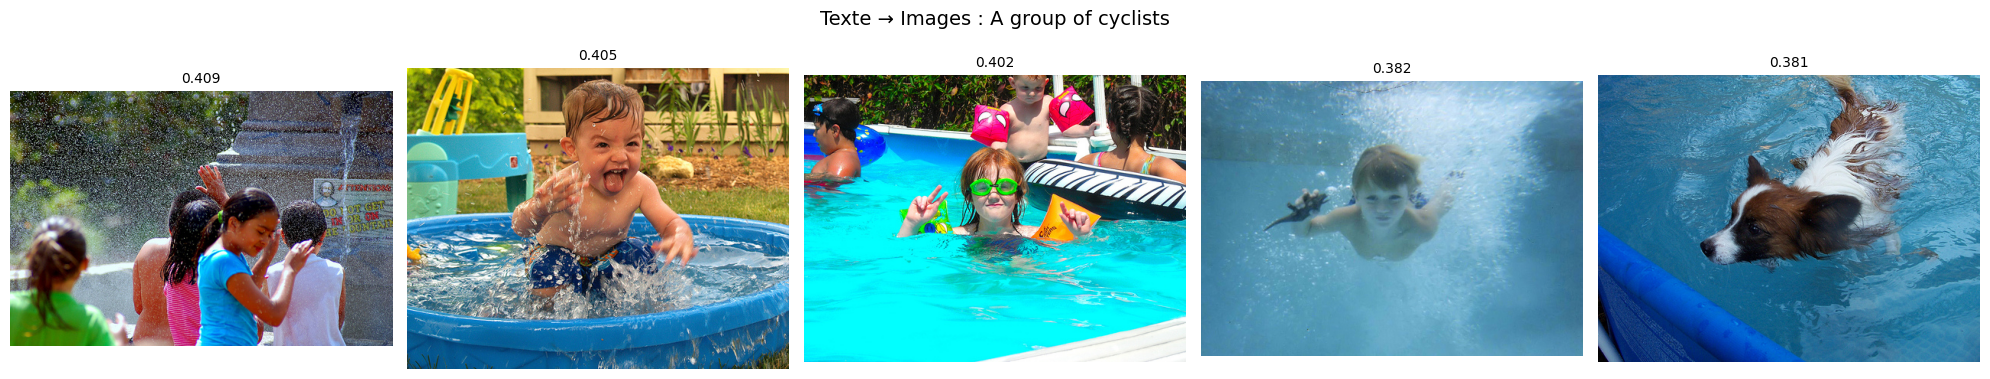


[IMAGE -> TEXTES] Query image: flickr_subset2/flickr_long_subset/images/water/water_1193.jpg
Top-5 captions (Image → Text)
01. score=0.3399 | caption=A playful black and white dog with distinctive spots on its face is seen running freely through a lush, sun-drenched dirt field, its tail wagging excitedly as it chases after something in the distance. The warm sunlight casts a gentle glow over the scene, illuminating the rough texture of the dirt beneath the dog's paws. In the background, a few trees stand tall, their leaves rustling gently in the breeze. | image_path=images/dog/dog_581.jpg
02. score=0.3229 | caption=The sun casts a warm glow over the lush green field, where a playful black and white dog runs with abandon, its tail wagging furiously as it chases after a ball of fluffy grass. The dog's paws barely touch the ground as it bounds effortlessly across the terrain, its joyful barks carrying on the breeze. In the distance, a few trees sway gently in the wind, their leaves rustl

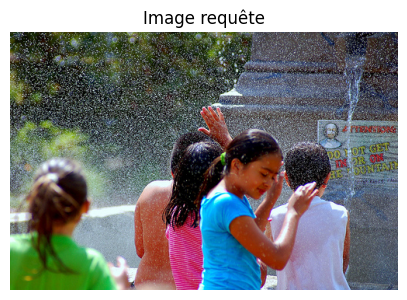

In [35]:
dataset_dir = "./flickr_subset2/flickr_long_subset"
image_dir = os.path.join(dataset_dir, "images")
captions_csv_path = os.path.join(dataset_dir, "captions.csv")

model_dir = "./models_forclip"
clip_model_path = os.path.join(model_dir, "clip_model.keras")
vocab_path = os.path.join(model_dir, "vocab.txt")

sequence_length = 32
embed_dim = 128
batch_size = 32
top_k = 5

# Ces globales seront remplies dans main()
clip = None
image_encoder = None
text_encoder = None
text_tokenizer = None


# ============================================================
# 2) Tokenizer depuis vocab.txt
# ============================================================

def load_vocab_txt(path):
    with open(path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip() != ""]

def build_tokenizer_from_vocab(vocab, sequence_length):
    # Ne PAS mettre max_tokens ici: évite l'erreur vocab > max_tokens
    tok = TextVectorization(
        output_sequence_length=sequence_length,
        standardize=None
    )
    tok.set_vocabulary(vocab)
    return tok


# ============================================================
# 3) Chargement CLIP + extraction des encodeurs
# ============================================================

def load_clip_and_encoders():
    global clip, image_encoder, text_encoder

    clip = tf.keras.models.load_model(
        clip_model_path,
        custom_objects={
            "L2Normalize": L2Normalize,
            "MaskedMean": MaskedMean,
            "PositionalEmbedding": PositionalEmbedding,
            "TransformerBlock": TransformerBlock,
            "SmallBERT": SmallBERT,
            "ClipLossLayer": ClipLossLayer
        }
    )
    image_encoder = clip.get_layer("image_encoder")
    text_encoder = clip.get_layer("text_encoder")
    print("CLIP loaded:", clip.name)
    print("Image encoder out:", image_encoder.output_shape,
          "| Text encoder out:", text_encoder.output_shape)


# ============================================================
# 4) Index (images / textes)
# ============================================================

def load_img_224(p):
    x = tf.io.read_file(p)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [224, 224])
    x = tf.image.convert_image_dtype(x, tf.float32)  # [0,1]
    return x

def build_image_index():
    global image_encoder
    gallery_paths = [str(p) for p in Path(image_dir).rglob("*.jpg")]

    ds_gallery = (tf.data.Dataset.from_tensor_slices(gallery_paths)
                  .map(load_img_224, num_parallel_calls=AUTOTUNE)
                  .batch(batch_size).prefetch(AUTOTUNE))

    gallery_embeds = image_encoder.predict(ds_gallery, verbose=1)  # (N,D)

    index_path = os.path.join(model_dir, "image_index.npz")
    np.savez_compressed(
        index_path,
        embeds=gallery_embeds.astype("float32"),
        paths=np.array(gallery_paths, dtype=np.str_)
    )
    print("Index image enregistré:", index_path, "| shape:", gallery_embeds.shape)
    return index_path

def build_text_index():
    global text_encoder, text_tokenizer
    caps_df = pd.read_csv(captions_csv_path)
    captions = caps_df["caption"].fillna("").astype(str).tolist()

    tokens = text_tokenizer(captions)  # (N,L)
    ds_text = (tf.data.Dataset.from_tensor_slices(tokens)
               .batch(batch_size).prefetch(AUTOTUNE))

    text_embeds = text_encoder.predict(ds_text, verbose=1)  # (N,D)

    text_index_path = os.path.join(model_dir, "text_index.npz")
    np.savez_compressed(
        text_index_path,
        embeds=text_embeds.astype("float32"),
        captions=np.array(captions, dtype=np.str_),
        image_paths=caps_df["image_path"].astype(str).to_numpy(dtype=np.str_)
    )
    print("Index texte enregistré:", text_index_path, "| shape:", text_embeds.shape)
    return text_index_path

def load_image_index():
    data = np.load(os.path.join(model_dir, "image_index.npz"))
    return data["embeds"], data["paths"].astype(str)

def load_text_index():
    data = np.load(os.path.join(model_dir, "text_index.npz"))
    return data["embeds"], data["captions"].astype(str), data["image_paths"].astype(str)


# ============================================================
# 5) Recherche (Texte->Images, Image->Textes)
# ============================================================

def search_images_by_text(query, image_embeds, image_paths, top_k=5):
    global text_tokenizer, text_encoder
    q_tokens = text_tokenizer([query])                  # (1,L)
    q_embed = text_encoder.predict(q_tokens, verbose=0) # (1,D)
    scores = (q_embed @ image_embeds.T)[0]              # (N,)
    idx = np.argsort(-scores)[:top_k]
    return [(image_paths[i], float(scores[i])) for i in idx]

def show_topk_images(results, title="Top-5 images", max_cols=5):
    n = len(results)
    cols = min(max_cols, n)
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle(title, fontsize=14)

    for i, (p, s) in enumerate(results):
        ax = plt.subplot(rows, cols, i + 1)
        img = mpimg.imread(p)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{s:.3f}", fontsize=10)
    plt.tight_layout()
    plt.show()

def preprocess_image_for_query(image_path):
    x = load_img_224(image_path)     # (224,224,3)
    x = tf.expand_dims(x, axis=0)    # (1,224,224,3)
    return x

def search_texts_by_image(image_path, text_embeds, captions, caps_img_paths, top_k=5):
    global image_encoder
    img = preprocess_image_for_query(image_path)
    q_embed = image_encoder.predict(img, verbose=0)     # (1,D)
    scores = (q_embed @ text_embeds.T)[0]               # (N,)
    idx = np.argsort(-scores)[:top_k]
    return [(captions[i], caps_img_paths[i], float(scores[i])) for i in idx]

def print_topk_captions(results, title="Top-5 captions"):
    print(title)
    for rank, (cap, img_p, s) in enumerate(results, start=1):
        print(f"{rank:02d}. score={s:.4f} | caption={cap} | image_path={img_p}")


# ============================================================
# 6) MAIN — démonstration 2 sens
# ============================================================

def main():
    global text_tokenizer

    # 1) tokenizer depuis vocab.txt
    vocab = load_vocab_txt(vocab_path)
    text_tokenizer = build_tokenizer_from_vocab(vocab, sequence_length)

    # 2) charger CLIP + encodeurs
    load_clip_and_encoders()

    # 3) construire les index si absents
    img_index_path = os.path.join(model_dir, "image_index.npz")
    txt_index_path = os.path.join(model_dir, "text_index.npz")

    if not os.path.exists(img_index_path):
        build_image_index()
    if not os.path.exists(txt_index_path):
        build_text_index()

    # 4) charger index
    image_embeds, image_paths = load_image_index()
    text_embeds, captions, caps_img_paths = load_text_index()

    print("Index loaded:",
          "image_embeds", image_embeds.shape, "paths", len(image_paths),
          "| text_embeds", text_embeds.shape, "captions", len(captions))

    # 5) TEXTE -> IMAGES
    query_text = "A group of cyclists"
    top_images = search_images_by_text(query_text, image_embeds, image_paths, top_k=top_k)

    print(f"\n[TEXTE -> IMAGES] Query: {query_text}")
    for p, s in top_images:
        print(f"score={s:.4f} | {p}")

    show_topk_images(top_images, title=f"Texte → Images : {query_text}")

    # 6) IMAGE -> TEXTES
    query_image = top_images[0][0]  # pour la démo, on prend la meilleure
    top_texts = search_texts_by_image(query_image, text_embeds, captions, caps_img_paths, top_k=top_k)

    print(f"\n[IMAGE -> TEXTES] Query image: {query_image}")
    print_topk_captions(top_texts, title="Top-5 captions (Image → Text)")

    # Afficher l'image requête (optionnel mais propre)
    plt.figure(figsize=(5, 5))
    plt.imshow(mpimg.imread(query_image))
    plt.axis("off")
    plt.title("Image requête")
    plt.show()


if __name__ == "__main__":
    main()

CLIP loaded: clip_model
Image encoder out: (None, 128) | Text encoder out: (None, 128)
Image embeds: (800, 128)
Text embeds : (800, 128)
Similarity matrix shape: (20, 20)


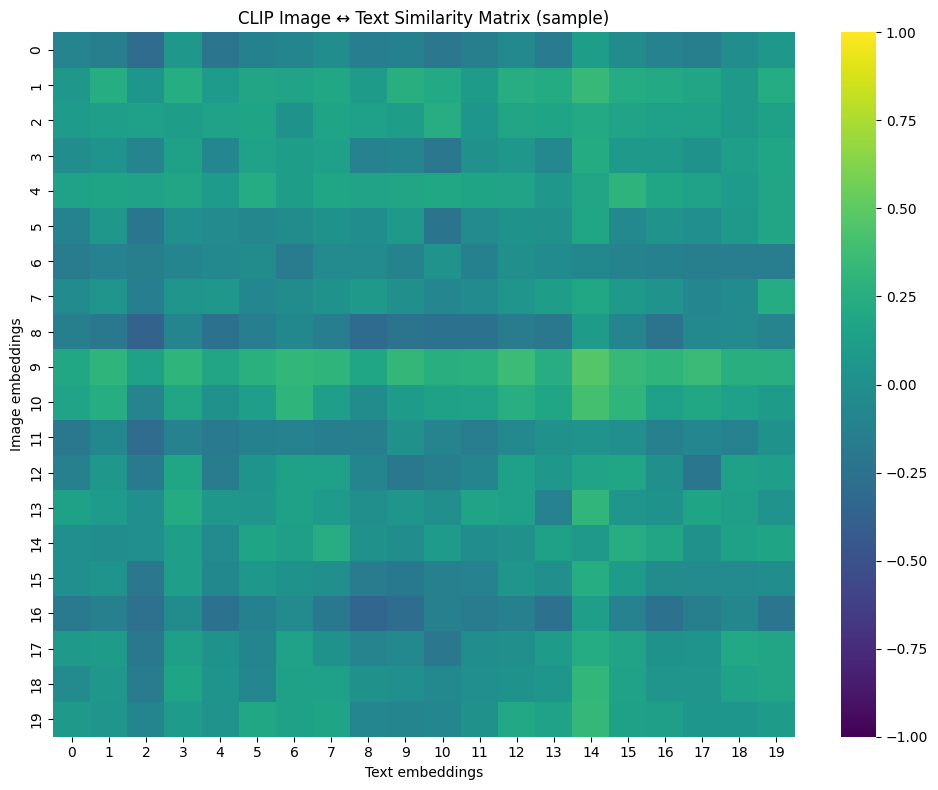

In [45]:
MODEL_DIR = "./models_forclip"
VOCAB_PATH = os.path.join(MODEL_DIR, "vocab.txt")
CLIP_MODEL_PATH = os.path.join(MODEL_DIR, "clip_model.keras")
IMAGE_INDEX_PATH = os.path.join(MODEL_DIR, "image_index.npz")
TEXT_INDEX_PATH = os.path.join(MODEL_DIR, "text_index.npz")
SEQUENCE_LENGTH = 32
EMBED_DIM = 128
BATCH_SIZE = 32
VOCAB_PATH = os.path.join(MODEL_DIR, "vocab.txt")
import seaborn as sns

def load_vocab_txt(path):
    with open(path, "r", encoding="utf-8") as f:
        return [l.strip() for l in f if l.strip()]

def build_tokenizer_from_vocab(vocab):
    tokenizer = TextVectorization(
        output_sequence_length=SEQUENCE_LENGTH,
        standardize=None
    )
    tokenizer.set_vocabulary(vocab)
    return tokenizer
# =========================================================
# Chargement CLIP + sous-encodeurs
# =========================================================
def load_clip_and_encoders():
    clip = tf.keras.models.load_model(
        CLIP_MODEL_PATH,
        compile=False
    )
    image_encoder = clip.get_layer("image_encoder")
    text_encoder  = clip.get_layer("text_encoder")
    print("CLIP loaded:", clip.name)
    print("Image encoder out:", image_encoder.output_shape,
          "| Text encoder out:", text_encoder.output_shape)
    return clip, image_encoder, text_encoder

# =========================================================
# Chargement des index
# =========================================================
def load_image_index():
    data = np.load(IMAGE_INDEX_PATH)
    return data["embeds"], data["paths"].astype(str)

def load_text_index():
    data = np.load(TEXT_INDEX_PATH)
    return (
        data["embeds"],
        data["captions"].astype(str),
        data["image_paths"].astype(str)
    )

# =========================================================
# Matrice de similarité
# =========================================================
def compute_similarity_matrix(image_embeds, text_embeds):
    """
    image_embeds : (N, D)
    text_embeds  : (M, D)
    return       : (N, M) cosine similarity
    """
    return image_embeds @ text_embeds.T

# =========================================================
# Visualisation
# =========================================================
def plot_similarity_matrix(sim_matrix, title="CLIP Similarity Matrix"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        sim_matrix,
        cmap="viridis",
        vmin=-1,
        vmax=1
    )
    plt.title(title)
    plt.xlabel("Text embeddings")
    plt.ylabel("Image embeddings")
    plt.tight_layout()
    plt.show()

# =========================================================
# MAIN
# =========================================================
def main():
    # --- Tokenizer ---
    vocab = load_vocab_txt(VOCAB_PATH)
    text_tokenizer = build_tokenizer_from_vocab(vocab)

    # --- CLIP ---
    clip, image_encoder, text_encoder = load_clip_and_encoders()

    # --- Index ---
    image_embeds, image_paths = load_image_index()
    text_embeds, captions, caps_img_paths = load_text_index()

    print("Image embeds:", image_embeds.shape)
    print("Text embeds :", text_embeds.shape)

    # --- Sous-échantillon pour visualisation ---
    N = 20  # matrice lisible
    image_embeds_small = image_embeds[:N]
    text_embeds_small  = text_embeds[:N]

    # --- Similarité ---
    sim_matrix = compute_similarity_matrix(
        image_embeds_small,
        text_embeds_small
    )

    print("Similarity matrix shape:", sim_matrix.shape)

    # --- Plot ---
    plot_similarity_matrix(
        sim_matrix,
        title="CLIP Image ↔ Text Similarity Matrix (sample)"
    )

if __name__ == "__main__":
    main()

2025-12-26 16:52:40.503602: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,32,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-26 16:52:40.603560: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,64,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,112,112]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

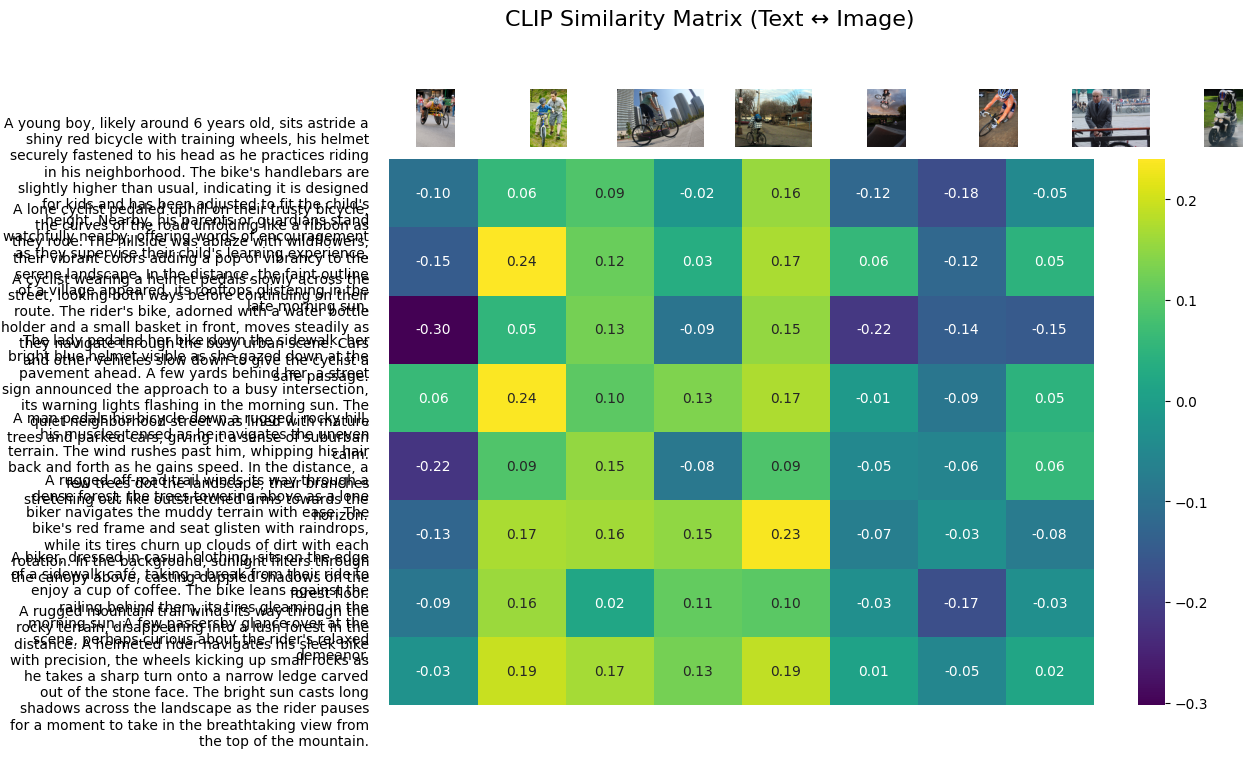

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from pathlib import Path

# =========================================================
# Paramètres
# =========================================================
TOP_K = 8      # nombre d’images
NB_TEXTS = 8   # nombre de textes
FIGSIZE = (14, 8)

# =========================================================
# Sélection d’exemples
# =========================================================
def select_examples(image_paths, captions, k_img=8, k_txt=8):
    imgs = image_paths[:k_img]
    txts = captions[:k_txt]
    return imgs, txts

# =========================================================
# Encodage
# =========================================================
def encode_images(image_paths, image_encoder):
    imgs = []
    for p in image_paths:
        x = tf.io.read_file(p)
        x = tf.image.decode_jpeg(x, channels=3)
        x = tf.image.resize(x, [224, 224])
        x = tf.image.convert_image_dtype(x, tf.float32)
        imgs.append(x)
    imgs = tf.stack(imgs)
    return image_encoder.predict(imgs, verbose=0)

def encode_texts(texts, tokenizer, text_encoder):
    tokens = tokenizer(texts)
    return text_encoder.predict(tokens, verbose=0)

# =========================================================
# Matrice de similarité
# =========================================================
def compute_similarity(text_embeds, image_embeds):
    # (T,D) x (D,I) -> (T,I)
    return text_embeds @ image_embeds.T

# =========================================================
# Visualisation CLIP-style
# =========================================================
def plot_clip_matrix(sim, texts, image_paths):
    fig = plt.figure(figsize=FIGSIZE)
    gs = fig.add_gridspec(
        nrows=len(texts)+1,
        ncols=len(image_paths)+1,
        width_ratios=[2] + [1]*len(image_paths),
        height_ratios=[1] + [1]*len(texts)
    )

    # ---- images en haut ----
    for j, p in enumerate(image_paths):
        ax = fig.add_subplot(gs[0, j+1])
        img = mpimg.imread(p)
        ax.imshow(img)
        ax.axis("off")

    # ---- textes à gauche ----
    for i, txt in enumerate(texts):
        ax = fig.add_subplot(gs[i+1, 0])
        ax.text(1, 0.5, txt, va="center", ha="right", fontsize=10, wrap=True)
        ax.axis("off")

    # ---- heatmap ----
    ax = fig.add_subplot(gs[1:, 1:])
    sns.heatmap(
        sim,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        cbar=True,
        xticklabels=False,
        yticklabels=False,
        ax=ax
    )

    plt.suptitle("CLIP Similarity Matrix (Text ↔ Image)", fontsize=16)
    plt.tight_layout()
    plt.show()

# =========================================================
# MAIN
# =========================================================
def main():
    # --- Charger index ---
    image_embeds, image_paths = load_image_index()
    text_embeds, captions, _ = load_text_index()

    # --- Tokenizer ---
    vocab = load_vocab_txt(os.path.join(MODEL_DIR, "vocab.txt"))
    tokenizer = build_tokenizer_from_vocab(vocab)

    # --- Sélection ---
    imgs, txts = select_examples(image_paths, captions, TOP_K, NB_TEXTS)

    # --- Encodage ---
    img_emb = encode_images(imgs, image_encoder)
    txt_emb = encode_texts(txts, tokenizer, text_encoder)

    # --- Similarité ---
    sim = compute_similarity(txt_emb, img_emb)

    # --- Plot ---
    plot_clip_matrix(sim, txts, imgs)

# =========================================================
# Lancement
# =========================================================
if __name__ == "__main__":
    main()
